In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import datetime

In [2]:
# Create a unique run name with timestamp
current_time = datetime.datetime.now().strftime('%b%d_%H-%M-%S')
writer = SummaryWriter(f'runs/LSTM_trajectory_prediction_{current_time}')

In [3]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [4]:
# Load the data
ally_data = np.load('Data/robot2_trajectories.npy', allow_pickle=True)
enemy_data = np.load('Data/robot3_trajectories.npy', allow_pickle=True)

In [5]:
print(ally_data)

[array([[ 5.59134875e+00,  1.41643597e+01, -1.84162532e+00,
         -2.49373810e-02],
        [ 5.56458846e+00,  1.40680067e+01, -1.84170073e+00,
         -7.54116236e-04],
        [ 5.53782097e+00,  1.39716558e+01, -1.84177530e+00,
         -7.45661649e-04],
        [ 5.51104649e+00,  1.38753068e+01, -1.84184799e+00,
         -7.26979995e-04],
        [ 5.48426527e+00,  1.37789597e+01, -1.84191789e+00,
         -6.98987479e-04],
        [ 5.45747770e+00,  1.36826143e+01, -1.84198379e+00,
         -6.58948722e-04],
        [ 5.43068432e+00,  1.35862706e+01, -1.84204411e+00,
         -6.03216329e-04],
        [ 5.40388586e+00,  1.34899283e+01, -1.84209680e+00,
         -5.26866748e-04],
        [ 5.37708333e+00,  1.33935871e+01, -1.84213911e+00,
         -4.23162505e-04],
        [ 5.35027807e+00,  1.32972467e+01, -1.84216739e+00,
         -2.82742963e-04],
        [ 5.32347193e+00,  1.32009065e+01, -1.84217662e+00,
         -9.23810312e-05],
        [ 5.29666739e+00,  1.31045659e+01, 

In [33]:
# Prepare data
def prepare_sequences(ally_data, enemy_data, sequence_length=10):
    X, y = [], []
    for ally_traj, enemy_traj in zip(ally_data, enemy_data):
        for i in range(len(ally_traj) - sequence_length):
            X.append(ally_traj[i:i+sequence_length, :3])  # x, y, theta
            y.append(enemy_traj[i+sequence_length, :2])  # x, y of enemy at next step
    return np.array(X), np.array(y)

In [34]:
X, y = prepare_sequences(ally_data, enemy_data)

In [35]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [36]:
np.shape(X_train)

(316089, 10, 3)

In [37]:
# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [38]:
# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [39]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=3, hidden_size1=32, hidden_size2=128, output_size=2):
        super(LSTMModel, self).__init__()
        
        # First LSTM layer: input_size -> hidden_size1
        self.lstm1 = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size1,
                            num_layers=1,
                            batch_first=True)
        
        # Second LSTM layer: hidden_size1 -> hidden_size2
        self.lstm2 = nn.LSTM(input_size=hidden_size1,
                            hidden_size=hidden_size2,
                            num_layers=1,
                            batch_first=True)
        
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size2, output_size)
        
        # Store sizes for forward pass
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2

    def forward(self, x):
        batch_size = x.size(0)
        
        # Initialize hidden states for first layer
        h0_1 = torch.zeros(1, batch_size, self.hidden_size1).to(x.device)
        c0_1 = torch.zeros(1, batch_size, self.hidden_size1).to(x.device)
        
        # First LSTM layer
        out1, _ = self.lstm1(x, (h0_1, c0_1))
        
        # Initialize hidden states for second layer
        h0_2 = torch.zeros(1, batch_size, self.hidden_size2).to(x.device)
        c0_2 = torch.zeros(1, batch_size, self.hidden_size2).to(x.device)
        
        # Second LSTM layer
        out2, _ = self.lstm2(out1, (h0_2, c0_2))
        
        # Take the output from the last time step
        out = self.dropout(out2[:, -1, :])
        out = self.fc(out)
        return out

# Instantiate the model
model = LSTMModel(input_size=3, hidden_size1=32, hidden_size2=128, output_size=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

dummy_input = torch.zeros(1, 10, 3).to(device)  # (batch_size, sequence_length, input_size)
writer.add_graph(model, dummy_input)

In [40]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [41]:
# Model size estimation
total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params}")
print(f"Approximate model size: {total_params * 4 / 1e6:.2f} MB")

Total trainable parameters: 87938
Approximate model size: 0.35 MB


In [42]:
# Input size check
for batch_X, batch_y in train_loader:
    print(f"Input shape: {batch_X.shape}")
    print(f"Input memory: {batch_X.nelement() * batch_X.element_size() / 1e6:.2f} MB")
    break

Input shape: torch.Size([128, 10, 3])
Input memory: 0.02 MB


In [43]:
def print_gpu_memory(description=""):
    print(f"\nGPU Memory Usage ({description}):")
    print(f"Allocated: {torch.cuda.memory_allocated() / 1e9:.2f}GB")
    print(f"Cached: {torch.cuda.memory_reserved() / 1e9:.2f}GB")

In [44]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                      mode='min',
                                                      factor=0.5,    # multiply LR by this factor
                                                      patience=10,   # number of epochs to wait
                                                      verbose=True)

/home/roar2/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [45]:
# Training loop
num_epochs = 1000
best_val_loss = float('inf')
total_steps = 0


for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Log training loss per step
        writer.add_scalar('Loss/train_step', loss.item(), total_steps)
        total_steps += 1
    
    # Calculate average training loss for the epoch
    avg_train_loss = train_loss / len(train_loader)
    writer.add_scalar('Loss/train_epoch', avg_train_loss, epoch)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            
    avg_val_loss = val_loss / len(val_loader)
    writer.add_scalar('Loss/validation', avg_val_loss, epoch)
    
    # Step the scheduler based on validation loss
    scheduler.step(avg_val_loss)
    
    # Log current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    writer.add_scalar('Learning_rate', current_lr, epoch)
    
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
        }, 'best_model.pth')
    
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Learning Rate: {current_lr:.6f}")
    
writer.close()


Epoch 1/1000: 100%|██████████| 2470/2470 [00:03<00:00, 634.09it/s]


Epoch [1/1000], Train Loss: 10.6164, Val Loss: 9.5018, Learning Rate: 0.001000


Epoch 2/1000: 100%|██████████| 2470/2470 [00:03<00:00, 629.94it/s]


Epoch [2/1000], Train Loss: 9.4461, Val Loss: 9.1572, Learning Rate: 0.001000


Epoch 3/1000: 100%|██████████| 2470/2470 [00:03<00:00, 637.71it/s]


Epoch [3/1000], Train Loss: 8.6077, Val Loss: 7.3973, Learning Rate: 0.001000


Epoch 4/1000: 100%|██████████| 2470/2470 [00:03<00:00, 637.59it/s]


Epoch [4/1000], Train Loss: 6.5427, Val Loss: 5.6962, Learning Rate: 0.001000


Epoch 5/1000: 100%|██████████| 2470/2470 [00:03<00:00, 633.78it/s]


Epoch [5/1000], Train Loss: 5.1602, Val Loss: 4.3234, Learning Rate: 0.001000


Epoch 6/1000: 100%|██████████| 2470/2470 [00:03<00:00, 637.38it/s]


Epoch [6/1000], Train Loss: 4.6385, Val Loss: 4.0122, Learning Rate: 0.001000


Epoch 7/1000: 100%|██████████| 2470/2470 [00:04<00:00, 571.56it/s]


Epoch [7/1000], Train Loss: 4.4053, Val Loss: 3.9351, Learning Rate: 0.001000


Epoch 8/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.70it/s]


Epoch [8/1000], Train Loss: 4.2151, Val Loss: 3.7583, Learning Rate: 0.001000


Epoch 9/1000: 100%|██████████| 2470/2470 [00:03<00:00, 643.55it/s]


Epoch [9/1000], Train Loss: 4.0409, Val Loss: 3.7118, Learning Rate: 0.001000


Epoch 10/1000: 100%|██████████| 2470/2470 [00:03<00:00, 630.82it/s]


Epoch [10/1000], Train Loss: 3.8493, Val Loss: 3.5547, Learning Rate: 0.001000


Epoch 11/1000: 100%|██████████| 2470/2470 [00:03<00:00, 620.97it/s]


Epoch [11/1000], Train Loss: 3.6723, Val Loss: 3.3214, Learning Rate: 0.001000


Epoch 12/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.55it/s]


Epoch [12/1000], Train Loss: 3.4880, Val Loss: 3.2148, Learning Rate: 0.001000


Epoch 13/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.65it/s]


Epoch [13/1000], Train Loss: 3.3089, Val Loss: 3.6193, Learning Rate: 0.001000


Epoch 14/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.53it/s]


Epoch [14/1000], Train Loss: 3.1732, Val Loss: 2.8512, Learning Rate: 0.001000


Epoch 15/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.04it/s]


Epoch [15/1000], Train Loss: 3.0489, Val Loss: 2.8286, Learning Rate: 0.001000


Epoch 16/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.22it/s]


Epoch [16/1000], Train Loss: 2.9527, Val Loss: 2.7587, Learning Rate: 0.001000


Epoch 17/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.82it/s]


Epoch [17/1000], Train Loss: 2.8395, Val Loss: 2.5793, Learning Rate: 0.001000


Epoch 18/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.28it/s]


Epoch [18/1000], Train Loss: 2.7797, Val Loss: 2.3748, Learning Rate: 0.001000


Epoch 19/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.52it/s]


Epoch [19/1000], Train Loss: 2.6941, Val Loss: 2.3902, Learning Rate: 0.001000


Epoch 20/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.26it/s]


Epoch [20/1000], Train Loss: 2.6281, Val Loss: 2.3654, Learning Rate: 0.001000


Epoch 21/1000: 100%|██████████| 2470/2470 [00:03<00:00, 628.88it/s]


Epoch [21/1000], Train Loss: 2.5494, Val Loss: 2.1861, Learning Rate: 0.001000


Epoch 22/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.42it/s]


Epoch [22/1000], Train Loss: 2.4852, Val Loss: 2.5328, Learning Rate: 0.001000


Epoch 23/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.86it/s]


Epoch [23/1000], Train Loss: 2.4259, Val Loss: 2.2208, Learning Rate: 0.001000


Epoch 24/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.12it/s]


Epoch [24/1000], Train Loss: 2.3886, Val Loss: 2.2795, Learning Rate: 0.001000


Epoch 25/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.18it/s]


Epoch [25/1000], Train Loss: 2.3316, Val Loss: 2.0883, Learning Rate: 0.001000


Epoch 26/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.84it/s]


Epoch [26/1000], Train Loss: 2.2938, Val Loss: 1.9952, Learning Rate: 0.001000


Epoch 27/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.34it/s]


Epoch [27/1000], Train Loss: 2.2365, Val Loss: 2.2503, Learning Rate: 0.001000


Epoch 28/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.53it/s]


Epoch [28/1000], Train Loss: 2.2039, Val Loss: 1.9886, Learning Rate: 0.001000


Epoch 29/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.83it/s]


Epoch [29/1000], Train Loss: 2.1552, Val Loss: 1.8685, Learning Rate: 0.001000


Epoch 30/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.69it/s]


Epoch [30/1000], Train Loss: 2.1109, Val Loss: 1.9688, Learning Rate: 0.001000


Epoch 31/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.16it/s]


Epoch [31/1000], Train Loss: 2.0675, Val Loss: 1.8835, Learning Rate: 0.001000


Epoch 32/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.46it/s]


Epoch [32/1000], Train Loss: 2.0197, Val Loss: 1.7578, Learning Rate: 0.001000


Epoch 33/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.08it/s]


Epoch [33/1000], Train Loss: 2.0042, Val Loss: 1.7965, Learning Rate: 0.001000


Epoch 34/1000: 100%|██████████| 2470/2470 [00:03<00:00, 631.48it/s]


Epoch [34/1000], Train Loss: 1.9712, Val Loss: 1.7936, Learning Rate: 0.001000


Epoch 35/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.51it/s]


Epoch [35/1000], Train Loss: 1.9279, Val Loss: 1.7209, Learning Rate: 0.001000


Epoch 36/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.39it/s]


Epoch [36/1000], Train Loss: 1.8887, Val Loss: 1.7463, Learning Rate: 0.001000


Epoch 37/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.67it/s]


Epoch [37/1000], Train Loss: 1.8713, Val Loss: 1.6912, Learning Rate: 0.001000


Epoch 38/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.16it/s]


Epoch [38/1000], Train Loss: 1.8176, Val Loss: 1.6208, Learning Rate: 0.001000


Epoch 39/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.62it/s]


Epoch [39/1000], Train Loss: 1.8027, Val Loss: 1.5828, Learning Rate: 0.001000


Epoch 40/1000: 100%|██████████| 2470/2470 [00:03<00:00, 622.37it/s]


Epoch [40/1000], Train Loss: 1.7702, Val Loss: 1.7173, Learning Rate: 0.001000


Epoch 41/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.24it/s]


Epoch [41/1000], Train Loss: 1.7392, Val Loss: 1.6125, Learning Rate: 0.001000


Epoch 42/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.47it/s]


Epoch [42/1000], Train Loss: 1.7169, Val Loss: 1.6554, Learning Rate: 0.001000


Epoch 43/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.52it/s]


Epoch [43/1000], Train Loss: 1.6937, Val Loss: 1.4905, Learning Rate: 0.001000


Epoch 44/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.10it/s]


Epoch [44/1000], Train Loss: 1.6600, Val Loss: 1.5717, Learning Rate: 0.001000


Epoch 45/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.52it/s]


Epoch [45/1000], Train Loss: 1.6465, Val Loss: 1.6246, Learning Rate: 0.001000


Epoch 46/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.41it/s]


Epoch [46/1000], Train Loss: 1.6229, Val Loss: 1.4629, Learning Rate: 0.001000


Epoch 47/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.07it/s]


Epoch [47/1000], Train Loss: 1.5854, Val Loss: 1.3842, Learning Rate: 0.001000


Epoch 48/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.78it/s]


Epoch [48/1000], Train Loss: 1.5657, Val Loss: 1.3605, Learning Rate: 0.001000


Epoch 49/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.30it/s]


Epoch [49/1000], Train Loss: 1.5502, Val Loss: 1.4186, Learning Rate: 0.001000


Epoch 50/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.78it/s]


Epoch [50/1000], Train Loss: 1.5263, Val Loss: 1.3569, Learning Rate: 0.001000


Epoch 51/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.12it/s]


Epoch [51/1000], Train Loss: 1.5003, Val Loss: 1.4024, Learning Rate: 0.001000


Epoch 52/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.63it/s]


Epoch [52/1000], Train Loss: 1.4856, Val Loss: 1.3515, Learning Rate: 0.001000


Epoch 53/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.72it/s]


Epoch [53/1000], Train Loss: 1.4634, Val Loss: 1.3094, Learning Rate: 0.001000


Epoch 54/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.67it/s]


Epoch [54/1000], Train Loss: 1.4475, Val Loss: 1.2951, Learning Rate: 0.001000


Epoch 55/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.85it/s]


Epoch [55/1000], Train Loss: 1.4317, Val Loss: 1.3111, Learning Rate: 0.001000


Epoch 56/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.79it/s]


Epoch [56/1000], Train Loss: 1.4113, Val Loss: 1.2138, Learning Rate: 0.001000


Epoch 57/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.54it/s]


Epoch [57/1000], Train Loss: 1.3865, Val Loss: 1.2651, Learning Rate: 0.001000


Epoch 58/1000: 100%|██████████| 2470/2470 [00:03<00:00, 645.83it/s]


Epoch [58/1000], Train Loss: 1.3898, Val Loss: 1.2959, Learning Rate: 0.001000


Epoch 59/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.81it/s]


Epoch [59/1000], Train Loss: 1.3642, Val Loss: 1.1541, Learning Rate: 0.001000


Epoch 60/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.08it/s]


Epoch [60/1000], Train Loss: 1.3428, Val Loss: 1.1988, Learning Rate: 0.001000


Epoch 61/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.88it/s]


Epoch [61/1000], Train Loss: 1.3358, Val Loss: 1.1695, Learning Rate: 0.001000


Epoch 62/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.38it/s]


Epoch [62/1000], Train Loss: 1.3222, Val Loss: 1.2816, Learning Rate: 0.001000


Epoch 63/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.16it/s]


Epoch [63/1000], Train Loss: 1.2957, Val Loss: 1.2187, Learning Rate: 0.001000


Epoch 64/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.29it/s]


Epoch [64/1000], Train Loss: 1.2938, Val Loss: 1.0928, Learning Rate: 0.001000


Epoch 65/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.03it/s]


Epoch [65/1000], Train Loss: 1.2725, Val Loss: 1.0696, Learning Rate: 0.001000


Epoch 66/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.47it/s]


Epoch [66/1000], Train Loss: 1.2641, Val Loss: 1.0447, Learning Rate: 0.001000


Epoch 67/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.16it/s]


Epoch [67/1000], Train Loss: 1.2496, Val Loss: 1.1445, Learning Rate: 0.001000


Epoch 68/1000: 100%|██████████| 2470/2470 [00:03<00:00, 639.92it/s]


Epoch [68/1000], Train Loss: 1.2394, Val Loss: 1.0790, Learning Rate: 0.001000


Epoch 69/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.23it/s]


Epoch [69/1000], Train Loss: 1.2162, Val Loss: 1.0288, Learning Rate: 0.001000


Epoch 70/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.18it/s]


Epoch [70/1000], Train Loss: 1.2209, Val Loss: 1.0523, Learning Rate: 0.001000


Epoch 71/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.16it/s]


Epoch [71/1000], Train Loss: 1.1959, Val Loss: 1.1632, Learning Rate: 0.001000


Epoch 72/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.36it/s]


Epoch [72/1000], Train Loss: 1.1945, Val Loss: 1.0363, Learning Rate: 0.001000


Epoch 73/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.92it/s]


Epoch [73/1000], Train Loss: 1.1796, Val Loss: 1.0805, Learning Rate: 0.001000


Epoch 74/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.78it/s]


Epoch [74/1000], Train Loss: 1.1679, Val Loss: 1.0072, Learning Rate: 0.001000


Epoch 75/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.81it/s]


Epoch [75/1000], Train Loss: 1.1436, Val Loss: 0.9898, Learning Rate: 0.001000


Epoch 76/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.98it/s]


Epoch [76/1000], Train Loss: 1.1512, Val Loss: 1.0734, Learning Rate: 0.001000


Epoch 77/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.00it/s]


Epoch [77/1000], Train Loss: 1.1193, Val Loss: 1.0662, Learning Rate: 0.001000


Epoch 78/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.02it/s]


Epoch [78/1000], Train Loss: 1.1159, Val Loss: 0.9694, Learning Rate: 0.001000


Epoch 79/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.52it/s]


Epoch [79/1000], Train Loss: 1.1060, Val Loss: 0.9614, Learning Rate: 0.001000


Epoch 80/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.84it/s]


Epoch [80/1000], Train Loss: 1.1105, Val Loss: 0.8948, Learning Rate: 0.001000


Epoch 81/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.71it/s]


Epoch [81/1000], Train Loss: 1.0903, Val Loss: 0.9343, Learning Rate: 0.001000


Epoch 82/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.94it/s]


Epoch [82/1000], Train Loss: 1.0897, Val Loss: 0.9653, Learning Rate: 0.001000


Epoch 83/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.80it/s]


Epoch [83/1000], Train Loss: 1.0850, Val Loss: 0.9807, Learning Rate: 0.001000


Epoch 84/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.47it/s]


Epoch [84/1000], Train Loss: 1.0571, Val Loss: 0.9394, Learning Rate: 0.001000


Epoch 85/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.69it/s]


Epoch [85/1000], Train Loss: 1.0678, Val Loss: 0.9089, Learning Rate: 0.001000


Epoch 86/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.49it/s]


Epoch [86/1000], Train Loss: 1.0566, Val Loss: 0.9480, Learning Rate: 0.001000


Epoch 87/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.00it/s]


Epoch [87/1000], Train Loss: 1.0365, Val Loss: 0.9032, Learning Rate: 0.001000


Epoch 88/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.06it/s]


Epoch [88/1000], Train Loss: 1.0441, Val Loss: 0.9080, Learning Rate: 0.001000


Epoch 89/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.16it/s]


Epoch [89/1000], Train Loss: 1.0329, Val Loss: 1.1456, Learning Rate: 0.001000


Epoch 90/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.99it/s]


Epoch [90/1000], Train Loss: 1.0130, Val Loss: 0.8430, Learning Rate: 0.001000


Epoch 91/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.40it/s]


Epoch [91/1000], Train Loss: 1.0264, Val Loss: 0.9623, Learning Rate: 0.001000


Epoch 92/1000: 100%|██████████| 2470/2470 [00:03<00:00, 621.38it/s]


Epoch [92/1000], Train Loss: 0.9996, Val Loss: 0.9084, Learning Rate: 0.001000


Epoch 93/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.66it/s]


Epoch [93/1000], Train Loss: 1.0059, Val Loss: 0.9113, Learning Rate: 0.001000


Epoch 94/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.89it/s]


Epoch [94/1000], Train Loss: 0.9934, Val Loss: 0.9946, Learning Rate: 0.001000


Epoch 95/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.47it/s]


Epoch [95/1000], Train Loss: 0.9825, Val Loss: 0.8348, Learning Rate: 0.001000


Epoch 96/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.83it/s]


Epoch [96/1000], Train Loss: 0.9766, Val Loss: 0.8181, Learning Rate: 0.001000


Epoch 97/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.46it/s]


Epoch [97/1000], Train Loss: 0.9686, Val Loss: 0.9426, Learning Rate: 0.001000


Epoch 98/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.53it/s]


Epoch [98/1000], Train Loss: 0.9681, Val Loss: 0.8701, Learning Rate: 0.001000


Epoch 99/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.33it/s]


Epoch [99/1000], Train Loss: 0.9669, Val Loss: 0.8295, Learning Rate: 0.001000


Epoch 100/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.74it/s]


Epoch [100/1000], Train Loss: 0.9527, Val Loss: 0.8658, Learning Rate: 0.001000


Epoch 101/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.57it/s]


Epoch [101/1000], Train Loss: 0.9534, Val Loss: 0.7569, Learning Rate: 0.001000


Epoch 102/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.86it/s]


Epoch [102/1000], Train Loss: 0.9375, Val Loss: 0.8319, Learning Rate: 0.001000


Epoch 103/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.45it/s]


Epoch [103/1000], Train Loss: 0.9418, Val Loss: 0.7842, Learning Rate: 0.001000


Epoch 104/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.93it/s]


Epoch [104/1000], Train Loss: 0.9324, Val Loss: 0.8709, Learning Rate: 0.001000


Epoch 105/1000: 100%|██████████| 2470/2470 [00:03<00:00, 628.69it/s]


Epoch [105/1000], Train Loss: 0.9303, Val Loss: 0.7777, Learning Rate: 0.001000


Epoch 106/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.01it/s]


Epoch [106/1000], Train Loss: 0.9229, Val Loss: 0.7586, Learning Rate: 0.001000


Epoch 107/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.26it/s]


Epoch [107/1000], Train Loss: 0.9093, Val Loss: 0.8256, Learning Rate: 0.001000


Epoch 108/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.76it/s]


Epoch [108/1000], Train Loss: 0.9113, Val Loss: 0.7982, Learning Rate: 0.001000


Epoch 109/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.98it/s]


Epoch [109/1000], Train Loss: 0.8988, Val Loss: 0.7329, Learning Rate: 0.001000


Epoch 110/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.01it/s]


Epoch [110/1000], Train Loss: 0.8938, Val Loss: 0.8272, Learning Rate: 0.001000


Epoch 111/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.77it/s]


Epoch [111/1000], Train Loss: 0.9102, Val Loss: 0.8006, Learning Rate: 0.001000


Epoch 112/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.18it/s]


Epoch [112/1000], Train Loss: 0.8842, Val Loss: 0.7872, Learning Rate: 0.001000


Epoch 113/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.12it/s]


Epoch [113/1000], Train Loss: 0.8860, Val Loss: 0.8568, Learning Rate: 0.001000


Epoch 114/1000: 100%|██████████| 2470/2470 [00:03<00:00, 643.85it/s]


Epoch [114/1000], Train Loss: 0.8726, Val Loss: 0.7434, Learning Rate: 0.001000


Epoch 115/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.81it/s]


Epoch [115/1000], Train Loss: 0.8723, Val Loss: 0.7612, Learning Rate: 0.001000


Epoch 116/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.62it/s]


Epoch [116/1000], Train Loss: 0.8684, Val Loss: 0.7622, Learning Rate: 0.001000


Epoch 117/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.77it/s]


Epoch [117/1000], Train Loss: 0.8646, Val Loss: 0.6805, Learning Rate: 0.001000


Epoch 118/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.89it/s]


Epoch [118/1000], Train Loss: 0.8596, Val Loss: 0.8323, Learning Rate: 0.001000


Epoch 119/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.81it/s]


Epoch [119/1000], Train Loss: 0.8619, Val Loss: 0.7289, Learning Rate: 0.001000


Epoch 120/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.50it/s]


Epoch [120/1000], Train Loss: 0.8533, Val Loss: 0.6851, Learning Rate: 0.001000


Epoch 121/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.81it/s]


Epoch [121/1000], Train Loss: 0.8450, Val Loss: 0.6602, Learning Rate: 0.001000


Epoch 122/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.31it/s]


Epoch [122/1000], Train Loss: 0.8381, Val Loss: 0.7915, Learning Rate: 0.001000


Epoch 123/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.18it/s]


Epoch [123/1000], Train Loss: 0.8466, Val Loss: 0.7166, Learning Rate: 0.001000


Epoch 124/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.48it/s]


Epoch [124/1000], Train Loss: 0.8420, Val Loss: 0.7033, Learning Rate: 0.001000


Epoch 125/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.83it/s]


Epoch [125/1000], Train Loss: 0.8337, Val Loss: 0.7510, Learning Rate: 0.001000


Epoch 126/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.10it/s]


Epoch [126/1000], Train Loss: 0.8306, Val Loss: 0.7265, Learning Rate: 0.001000


Epoch 127/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.05it/s]


Epoch [127/1000], Train Loss: 0.8208, Val Loss: 0.7245, Learning Rate: 0.001000


Epoch 128/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.26it/s]


Epoch [128/1000], Train Loss: 0.8228, Val Loss: 0.6651, Learning Rate: 0.001000


Epoch 129/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.43it/s]


Epoch [129/1000], Train Loss: 0.8252, Val Loss: 0.6610, Learning Rate: 0.001000


Epoch 130/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.62it/s]


Epoch [130/1000], Train Loss: 0.8203, Val Loss: 0.7225, Learning Rate: 0.001000


Epoch 131/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.00it/s]


Epoch [131/1000], Train Loss: 0.8112, Val Loss: 0.8146, Learning Rate: 0.001000


Epoch 132/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.14it/s]


Epoch [132/1000], Train Loss: 0.8161, Val Loss: 0.6992, Learning Rate: 0.000500


Epoch 133/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.34it/s]


Epoch [133/1000], Train Loss: 0.6374, Val Loss: 0.5543, Learning Rate: 0.000500


Epoch 134/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.03it/s]


Epoch [134/1000], Train Loss: 0.6312, Val Loss: 0.5284, Learning Rate: 0.000500


Epoch 135/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.95it/s]


Epoch [135/1000], Train Loss: 0.6269, Val Loss: 0.5299, Learning Rate: 0.000500


Epoch 136/1000: 100%|██████████| 2470/2470 [00:03<00:00, 642.27it/s]


Epoch [136/1000], Train Loss: 0.6227, Val Loss: 0.5225, Learning Rate: 0.000500


Epoch 137/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.64it/s]


Epoch [137/1000], Train Loss: 0.6152, Val Loss: 0.5987, Learning Rate: 0.000500


Epoch 138/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.45it/s]


Epoch [138/1000], Train Loss: 0.6078, Val Loss: 0.4962, Learning Rate: 0.000500


Epoch 139/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.52it/s]


Epoch [139/1000], Train Loss: 0.6087, Val Loss: 0.5562, Learning Rate: 0.000500


Epoch 140/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.17it/s]


Epoch [140/1000], Train Loss: 0.6025, Val Loss: 0.4941, Learning Rate: 0.000500


Epoch 141/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.51it/s]


Epoch [141/1000], Train Loss: 0.6037, Val Loss: 0.5555, Learning Rate: 0.000500


Epoch 142/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.73it/s]


Epoch [142/1000], Train Loss: 0.5997, Val Loss: 0.5412, Learning Rate: 0.000500


Epoch 143/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.92it/s]


Epoch [143/1000], Train Loss: 0.5931, Val Loss: 0.5120, Learning Rate: 0.000500


Epoch 144/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.33it/s]


Epoch [144/1000], Train Loss: 0.5927, Val Loss: 0.4886, Learning Rate: 0.000500


Epoch 145/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.95it/s]


Epoch [145/1000], Train Loss: 0.5877, Val Loss: 0.4932, Learning Rate: 0.000500


Epoch 146/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.69it/s]


Epoch [146/1000], Train Loss: 0.5889, Val Loss: 0.4883, Learning Rate: 0.000500


Epoch 147/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.13it/s]


Epoch [147/1000], Train Loss: 0.5850, Val Loss: 0.4974, Learning Rate: 0.000500


Epoch 148/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.24it/s]


Epoch [148/1000], Train Loss: 0.5802, Val Loss: 0.5019, Learning Rate: 0.000500


Epoch 149/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.80it/s]


Epoch [149/1000], Train Loss: 0.5808, Val Loss: 0.4730, Learning Rate: 0.000500


Epoch 150/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.83it/s]


Epoch [150/1000], Train Loss: 0.5802, Val Loss: 0.4661, Learning Rate: 0.000500


Epoch 151/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.57it/s]


Epoch [151/1000], Train Loss: 0.5755, Val Loss: 0.4821, Learning Rate: 0.000500


Epoch 152/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.33it/s]


Epoch [152/1000], Train Loss: 0.5753, Val Loss: 0.4596, Learning Rate: 0.000500


Epoch 153/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.30it/s]


Epoch [153/1000], Train Loss: 0.5681, Val Loss: 0.5126, Learning Rate: 0.000500


Epoch 154/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.43it/s]


Epoch [154/1000], Train Loss: 0.5709, Val Loss: 0.4544, Learning Rate: 0.000500


Epoch 155/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.63it/s]


Epoch [155/1000], Train Loss: 0.5724, Val Loss: 0.4463, Learning Rate: 0.000500


Epoch 156/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.48it/s]


Epoch [156/1000], Train Loss: 0.5701, Val Loss: 0.4752, Learning Rate: 0.000500


Epoch 157/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.91it/s]


Epoch [157/1000], Train Loss: 0.5607, Val Loss: 0.5609, Learning Rate: 0.000500


Epoch 158/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.54it/s]


Epoch [158/1000], Train Loss: 0.5619, Val Loss: 0.4889, Learning Rate: 0.000500


Epoch 159/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.27it/s]


Epoch [159/1000], Train Loss: 0.5618, Val Loss: 0.5529, Learning Rate: 0.000500


Epoch 160/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.61it/s]


Epoch [160/1000], Train Loss: 0.5556, Val Loss: 0.4651, Learning Rate: 0.000500


Epoch 161/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.53it/s]


Epoch [161/1000], Train Loss: 0.5567, Val Loss: 0.4723, Learning Rate: 0.000500


Epoch 162/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.61it/s]


Epoch [162/1000], Train Loss: 0.5532, Val Loss: 0.4327, Learning Rate: 0.000500


Epoch 163/1000: 100%|██████████| 2470/2470 [00:03<00:00, 622.14it/s]


Epoch [163/1000], Train Loss: 0.5479, Val Loss: 0.4278, Learning Rate: 0.000500


Epoch 164/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.26it/s]


Epoch [164/1000], Train Loss: 0.5458, Val Loss: 0.5073, Learning Rate: 0.000500


Epoch 165/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.53it/s]


Epoch [165/1000], Train Loss: 0.5478, Val Loss: 0.4480, Learning Rate: 0.000500


Epoch 166/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.36it/s]


Epoch [166/1000], Train Loss: 0.5518, Val Loss: 0.4422, Learning Rate: 0.000500


Epoch 167/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.68it/s]


Epoch [167/1000], Train Loss: 0.5424, Val Loss: 0.4263, Learning Rate: 0.000500


Epoch 168/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.86it/s]


Epoch [168/1000], Train Loss: 0.5451, Val Loss: 0.4741, Learning Rate: 0.000500


Epoch 169/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.44it/s]


Epoch [169/1000], Train Loss: 0.5458, Val Loss: 0.4615, Learning Rate: 0.000500


Epoch 170/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.64it/s]


Epoch [170/1000], Train Loss: 0.5379, Val Loss: 0.4600, Learning Rate: 0.000500


Epoch 171/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.55it/s]


Epoch [171/1000], Train Loss: 0.5381, Val Loss: 0.5086, Learning Rate: 0.000500


Epoch 172/1000: 100%|██████████| 2470/2470 [00:03<00:00, 646.28it/s]


Epoch [172/1000], Train Loss: 0.5403, Val Loss: 0.4765, Learning Rate: 0.000500


Epoch 173/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.50it/s]


Epoch [173/1000], Train Loss: 0.5387, Val Loss: 0.4534, Learning Rate: 0.000500


Epoch 174/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.01it/s]


Epoch [174/1000], Train Loss: 0.5296, Val Loss: 0.4476, Learning Rate: 0.000500


Epoch 175/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.79it/s]


Epoch [175/1000], Train Loss: 0.5320, Val Loss: 0.4493, Learning Rate: 0.000500


Epoch 176/1000: 100%|██████████| 2470/2470 [00:03<00:00, 635.67it/s]


Epoch [176/1000], Train Loss: 0.5285, Val Loss: 0.4235, Learning Rate: 0.000500


Epoch 177/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.31it/s]


Epoch [177/1000], Train Loss: 0.5268, Val Loss: 0.4543, Learning Rate: 0.000500


Epoch 178/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.47it/s]


Epoch [178/1000], Train Loss: 0.5280, Val Loss: 0.4132, Learning Rate: 0.000500


Epoch 179/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.65it/s]


Epoch [179/1000], Train Loss: 0.5291, Val Loss: 0.4177, Learning Rate: 0.000500


Epoch 180/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.37it/s]


Epoch [180/1000], Train Loss: 0.5314, Val Loss: 0.4557, Learning Rate: 0.000500


Epoch 181/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.87it/s]


Epoch [181/1000], Train Loss: 0.5277, Val Loss: 0.4360, Learning Rate: 0.000500


Epoch 182/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.18it/s]


Epoch [182/1000], Train Loss: 0.5241, Val Loss: 0.4192, Learning Rate: 0.000500


Epoch 183/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.85it/s]


Epoch [183/1000], Train Loss: 0.5231, Val Loss: 0.4397, Learning Rate: 0.000500


Epoch 184/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.11it/s]


Epoch [184/1000], Train Loss: 0.5229, Val Loss: 0.4255, Learning Rate: 0.000500


Epoch 185/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.12it/s]


Epoch [185/1000], Train Loss: 0.5183, Val Loss: 0.4179, Learning Rate: 0.000500


Epoch 186/1000: 100%|██████████| 2470/2470 [00:03<00:00, 646.56it/s]


Epoch [186/1000], Train Loss: 0.5139, Val Loss: 0.4483, Learning Rate: 0.000500


Epoch 187/1000: 100%|██████████| 2470/2470 [00:03<00:00, 646.25it/s]


Epoch [187/1000], Train Loss: 0.5181, Val Loss: 0.4359, Learning Rate: 0.000500


Epoch 188/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.66it/s]


Epoch [188/1000], Train Loss: 0.5197, Val Loss: 0.5013, Learning Rate: 0.000500


Epoch 189/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.32it/s]


Epoch [189/1000], Train Loss: 0.5165, Val Loss: 0.4375, Learning Rate: 0.000250


Epoch 190/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.60it/s]


Epoch [190/1000], Train Loss: 0.4475, Val Loss: 0.3653, Learning Rate: 0.000250


Epoch 191/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.90it/s]


Epoch [191/1000], Train Loss: 0.4432, Val Loss: 0.3628, Learning Rate: 0.000250


Epoch 192/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.70it/s]


Epoch [192/1000], Train Loss: 0.4447, Val Loss: 0.3602, Learning Rate: 0.000250


Epoch 193/1000: 100%|██████████| 2470/2470 [00:03<00:00, 643.00it/s]


Epoch [193/1000], Train Loss: 0.4427, Val Loss: 0.3639, Learning Rate: 0.000250


Epoch 194/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.33it/s]


Epoch [194/1000], Train Loss: 0.4400, Val Loss: 0.3672, Learning Rate: 0.000250


Epoch 195/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.30it/s]


Epoch [195/1000], Train Loss: 0.4375, Val Loss: 0.3492, Learning Rate: 0.000250


Epoch 196/1000: 100%|██████████| 2470/2470 [00:03<00:00, 621.23it/s]


Epoch [196/1000], Train Loss: 0.4382, Val Loss: 0.3553, Learning Rate: 0.000250


Epoch 197/1000: 100%|██████████| 2470/2470 [00:03<00:00, 633.35it/s]


Epoch [197/1000], Train Loss: 0.4355, Val Loss: 0.3611, Learning Rate: 0.000250


Epoch 198/1000: 100%|██████████| 2470/2470 [00:03<00:00, 635.63it/s]


Epoch [198/1000], Train Loss: 0.4347, Val Loss: 0.3512, Learning Rate: 0.000250


Epoch 199/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.57it/s]


Epoch [199/1000], Train Loss: 0.4339, Val Loss: 0.3608, Learning Rate: 0.000250


Epoch 200/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.65it/s]


Epoch [200/1000], Train Loss: 0.4316, Val Loss: 0.3559, Learning Rate: 0.000250


Epoch 201/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.13it/s]


Epoch [201/1000], Train Loss: 0.4331, Val Loss: 0.3530, Learning Rate: 0.000250


Epoch 202/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.97it/s]


Epoch [202/1000], Train Loss: 0.4314, Val Loss: 0.3750, Learning Rate: 0.000250


Epoch 203/1000: 100%|██████████| 2470/2470 [00:03<00:00, 645.57it/s]


Epoch [203/1000], Train Loss: 0.4299, Val Loss: 0.3642, Learning Rate: 0.000250


Epoch 204/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.81it/s]


Epoch [204/1000], Train Loss: 0.4312, Val Loss: 0.3630, Learning Rate: 0.000250


Epoch 205/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.36it/s]


Epoch [205/1000], Train Loss: 0.4286, Val Loss: 0.3583, Learning Rate: 0.000250


Epoch 206/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.54it/s]


Epoch [206/1000], Train Loss: 0.4304, Val Loss: 0.3480, Learning Rate: 0.000250


Epoch 207/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.64it/s]


Epoch [207/1000], Train Loss: 0.4258, Val Loss: 0.3620, Learning Rate: 0.000250


Epoch 208/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.02it/s]


Epoch [208/1000], Train Loss: 0.4242, Val Loss: 0.3632, Learning Rate: 0.000250


Epoch 209/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.91it/s]


Epoch [209/1000], Train Loss: 0.4259, Val Loss: 0.3505, Learning Rate: 0.000250


Epoch 210/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.57it/s]


Epoch [210/1000], Train Loss: 0.4242, Val Loss: 0.3452, Learning Rate: 0.000250


Epoch 211/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.52it/s]


Epoch [211/1000], Train Loss: 0.4218, Val Loss: 0.3428, Learning Rate: 0.000250


Epoch 212/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.04it/s]


Epoch [212/1000], Train Loss: 0.4229, Val Loss: 0.3480, Learning Rate: 0.000250


Epoch 213/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.05it/s]


Epoch [213/1000], Train Loss: 0.4183, Val Loss: 0.3537, Learning Rate: 0.000250


Epoch 214/1000: 100%|██████████| 2470/2470 [00:03<00:00, 634.91it/s]


Epoch [214/1000], Train Loss: 0.4206, Val Loss: 0.3484, Learning Rate: 0.000250


Epoch 215/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.74it/s]


Epoch [215/1000], Train Loss: 0.4231, Val Loss: 0.3693, Learning Rate: 0.000250


Epoch 216/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.98it/s]


Epoch [216/1000], Train Loss: 0.4182, Val Loss: 0.3469, Learning Rate: 0.000250


Epoch 217/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.94it/s]


Epoch [217/1000], Train Loss: 0.4159, Val Loss: 0.3332, Learning Rate: 0.000250


Epoch 218/1000: 100%|██████████| 2470/2470 [00:03<00:00, 643.23it/s]


Epoch [218/1000], Train Loss: 0.4170, Val Loss: 0.3679, Learning Rate: 0.000250


Epoch 219/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.26it/s]


Epoch [219/1000], Train Loss: 0.4174, Val Loss: 0.3597, Learning Rate: 0.000250


Epoch 220/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.78it/s]


Epoch [220/1000], Train Loss: 0.4146, Val Loss: 0.3433, Learning Rate: 0.000250


Epoch 221/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.98it/s]


Epoch [221/1000], Train Loss: 0.4161, Val Loss: 0.3375, Learning Rate: 0.000250


Epoch 222/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.72it/s]


Epoch [222/1000], Train Loss: 0.4151, Val Loss: 0.3461, Learning Rate: 0.000250


Epoch 223/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.76it/s]


Epoch [223/1000], Train Loss: 0.4114, Val Loss: 0.3345, Learning Rate: 0.000250


Epoch 224/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.99it/s]


Epoch [224/1000], Train Loss: 0.4115, Val Loss: 0.3352, Learning Rate: 0.000250


Epoch 225/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.88it/s]


Epoch [225/1000], Train Loss: 0.4134, Val Loss: 0.3429, Learning Rate: 0.000250


Epoch 226/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.99it/s]


Epoch [226/1000], Train Loss: 0.4120, Val Loss: 0.3579, Learning Rate: 0.000250


Epoch 227/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.84it/s]


Epoch [227/1000], Train Loss: 0.4117, Val Loss: 0.3374, Learning Rate: 0.000250


Epoch 228/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.81it/s]


Epoch [228/1000], Train Loss: 0.4128, Val Loss: 0.3407, Learning Rate: 0.000125


Epoch 229/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.18it/s]


Epoch [229/1000], Train Loss: 0.3855, Val Loss: 0.3164, Learning Rate: 0.000125


Epoch 230/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.34it/s]


Epoch [230/1000], Train Loss: 0.3844, Val Loss: 0.3213, Learning Rate: 0.000125


Epoch 231/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.20it/s]


Epoch [231/1000], Train Loss: 0.3825, Val Loss: 0.3142, Learning Rate: 0.000125


Epoch 232/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.80it/s]


Epoch [232/1000], Train Loss: 0.3831, Val Loss: 0.3155, Learning Rate: 0.000125


Epoch 233/1000: 100%|██████████| 2470/2470 [00:04<00:00, 613.02it/s]


Epoch [233/1000], Train Loss: 0.3827, Val Loss: 0.3147, Learning Rate: 0.000125


Epoch 234/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.99it/s]


Epoch [234/1000], Train Loss: 0.3804, Val Loss: 0.3159, Learning Rate: 0.000125


Epoch 235/1000: 100%|██████████| 2470/2470 [00:03<00:00, 645.08it/s]


Epoch [235/1000], Train Loss: 0.3809, Val Loss: 0.3122, Learning Rate: 0.000125


Epoch 236/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.87it/s]


Epoch [236/1000], Train Loss: 0.3819, Val Loss: 0.3122, Learning Rate: 0.000125


Epoch 237/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.11it/s]


Epoch [237/1000], Train Loss: 0.3794, Val Loss: 0.3067, Learning Rate: 0.000125


Epoch 238/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.67it/s]


Epoch [238/1000], Train Loss: 0.3794, Val Loss: 0.3111, Learning Rate: 0.000125


Epoch 239/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.25it/s]


Epoch [239/1000], Train Loss: 0.3779, Val Loss: 0.3095, Learning Rate: 0.000125


Epoch 240/1000: 100%|██████████| 2470/2470 [00:03<00:00, 643.55it/s]


Epoch [240/1000], Train Loss: 0.3777, Val Loss: 0.3101, Learning Rate: 0.000125


Epoch 241/1000: 100%|██████████| 2470/2470 [00:04<00:00, 609.29it/s]


Epoch [241/1000], Train Loss: 0.3774, Val Loss: 0.3115, Learning Rate: 0.000125


Epoch 242/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.57it/s]


Epoch [242/1000], Train Loss: 0.3769, Val Loss: 0.3080, Learning Rate: 0.000125


Epoch 243/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.70it/s]


Epoch [243/1000], Train Loss: 0.3776, Val Loss: 0.3113, Learning Rate: 0.000125


Epoch 244/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.78it/s]


Epoch [244/1000], Train Loss: 0.3775, Val Loss: 0.3089, Learning Rate: 0.000125


Epoch 245/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.48it/s]


Epoch [245/1000], Train Loss: 0.3764, Val Loss: 0.3183, Learning Rate: 0.000125


Epoch 246/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.60it/s]


Epoch [246/1000], Train Loss: 0.3759, Val Loss: 0.3106, Learning Rate: 0.000125


Epoch 247/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.62it/s]


Epoch [247/1000], Train Loss: 0.3760, Val Loss: 0.3108, Learning Rate: 0.000125


Epoch 248/1000: 100%|██████████| 2470/2470 [00:03<00:00, 643.27it/s]


Epoch [248/1000], Train Loss: 0.3767, Val Loss: 0.3083, Learning Rate: 0.000063


Epoch 249/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.24it/s]


Epoch [249/1000], Train Loss: 0.3648, Val Loss: 0.2990, Learning Rate: 0.000063


Epoch 250/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.17it/s]


Epoch [250/1000], Train Loss: 0.3637, Val Loss: 0.3030, Learning Rate: 0.000063


Epoch 251/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.61it/s]


Epoch [251/1000], Train Loss: 0.3635, Val Loss: 0.2986, Learning Rate: 0.000063


Epoch 252/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.80it/s]


Epoch [252/1000], Train Loss: 0.3619, Val Loss: 0.2969, Learning Rate: 0.000063


Epoch 253/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.96it/s]


Epoch [253/1000], Train Loss: 0.3632, Val Loss: 0.3000, Learning Rate: 0.000063


Epoch 254/1000: 100%|██████████| 2470/2470 [00:04<00:00, 587.96it/s]


Epoch [254/1000], Train Loss: 0.3631, Val Loss: 0.2981, Learning Rate: 0.000063


Epoch 255/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.28it/s]


Epoch [255/1000], Train Loss: 0.3615, Val Loss: 0.2990, Learning Rate: 0.000063


Epoch 256/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.90it/s]


Epoch [256/1000], Train Loss: 0.3605, Val Loss: 0.2979, Learning Rate: 0.000063


Epoch 257/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.04it/s]


Epoch [257/1000], Train Loss: 0.3610, Val Loss: 0.3055, Learning Rate: 0.000063


Epoch 258/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.16it/s]


Epoch [258/1000], Train Loss: 0.3612, Val Loss: 0.2964, Learning Rate: 0.000063


Epoch 259/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.73it/s]


Epoch [259/1000], Train Loss: 0.3606, Val Loss: 0.2963, Learning Rate: 0.000063


Epoch 260/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.37it/s]


Epoch [260/1000], Train Loss: 0.3594, Val Loss: 0.2949, Learning Rate: 0.000063


Epoch 261/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.13it/s]


Epoch [261/1000], Train Loss: 0.3616, Val Loss: 0.2965, Learning Rate: 0.000063


Epoch 262/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.63it/s]


Epoch [262/1000], Train Loss: 0.3588, Val Loss: 0.2954, Learning Rate: 0.000063


Epoch 263/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.70it/s]


Epoch [263/1000], Train Loss: 0.3605, Val Loss: 0.2963, Learning Rate: 0.000063


Epoch 264/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.57it/s]


Epoch [264/1000], Train Loss: 0.3590, Val Loss: 0.2936, Learning Rate: 0.000063


Epoch 265/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.46it/s]


Epoch [265/1000], Train Loss: 0.3595, Val Loss: 0.2968, Learning Rate: 0.000063


Epoch 266/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.43it/s]


Epoch [266/1000], Train Loss: 0.3592, Val Loss: 0.2955, Learning Rate: 0.000063


Epoch 267/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.92it/s]


Epoch [267/1000], Train Loss: 0.3593, Val Loss: 0.2962, Learning Rate: 0.000063


Epoch 268/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.55it/s]


Epoch [268/1000], Train Loss: 0.3584, Val Loss: 0.2951, Learning Rate: 0.000063


Epoch 269/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.81it/s]


Epoch [269/1000], Train Loss: 0.3587, Val Loss: 0.2936, Learning Rate: 0.000063


Epoch 270/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.19it/s]


Epoch [270/1000], Train Loss: 0.3579, Val Loss: 0.2935, Learning Rate: 0.000063


Epoch 271/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.31it/s]


Epoch [271/1000], Train Loss: 0.3579, Val Loss: 0.2966, Learning Rate: 0.000063


Epoch 272/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.91it/s]


Epoch [272/1000], Train Loss: 0.3584, Val Loss: 0.2929, Learning Rate: 0.000063


Epoch 273/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.59it/s]


Epoch [273/1000], Train Loss: 0.3567, Val Loss: 0.2949, Learning Rate: 0.000063


Epoch 274/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.31it/s]


Epoch [274/1000], Train Loss: 0.3576, Val Loss: 0.2917, Learning Rate: 0.000063


Epoch 275/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.49it/s]


Epoch [275/1000], Train Loss: 0.3583, Val Loss: 0.2930, Learning Rate: 0.000063


Epoch 276/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.52it/s]


Epoch [276/1000], Train Loss: 0.3571, Val Loss: 0.2935, Learning Rate: 0.000063


Epoch 277/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.00it/s]


Epoch [277/1000], Train Loss: 0.3571, Val Loss: 0.2944, Learning Rate: 0.000063


Epoch 278/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.73it/s]


Epoch [278/1000], Train Loss: 0.3572, Val Loss: 0.2943, Learning Rate: 0.000063


Epoch 279/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.21it/s]


Epoch [279/1000], Train Loss: 0.3559, Val Loss: 0.2939, Learning Rate: 0.000063


Epoch 280/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.37it/s]


Epoch [280/1000], Train Loss: 0.3558, Val Loss: 0.2942, Learning Rate: 0.000063


Epoch 281/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.05it/s]


Epoch [281/1000], Train Loss: 0.3567, Val Loss: 0.2931, Learning Rate: 0.000063


Epoch 282/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.56it/s]


Epoch [282/1000], Train Loss: 0.3561, Val Loss: 0.2912, Learning Rate: 0.000063


Epoch 283/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.19it/s]


Epoch [283/1000], Train Loss: 0.3546, Val Loss: 0.2951, Learning Rate: 0.000063


Epoch 284/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.26it/s]


Epoch [284/1000], Train Loss: 0.3556, Val Loss: 0.2908, Learning Rate: 0.000063


Epoch 285/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.78it/s]


Epoch [285/1000], Train Loss: 0.3552, Val Loss: 0.2932, Learning Rate: 0.000063


Epoch 286/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.32it/s]


Epoch [286/1000], Train Loss: 0.3541, Val Loss: 0.2978, Learning Rate: 0.000063


Epoch 287/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.71it/s]


Epoch [287/1000], Train Loss: 0.3549, Val Loss: 0.2918, Learning Rate: 0.000063


Epoch 288/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.27it/s]


Epoch [288/1000], Train Loss: 0.3549, Val Loss: 0.2935, Learning Rate: 0.000063


Epoch 289/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.00it/s]


Epoch [289/1000], Train Loss: 0.3540, Val Loss: 0.2912, Learning Rate: 0.000063


Epoch 290/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.95it/s]


Epoch [290/1000], Train Loss: 0.3529, Val Loss: 0.2918, Learning Rate: 0.000063


Epoch 291/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.17it/s]


Epoch [291/1000], Train Loss: 0.3541, Val Loss: 0.2910, Learning Rate: 0.000063


Epoch 292/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.41it/s]


Epoch [292/1000], Train Loss: 0.3539, Val Loss: 0.2900, Learning Rate: 0.000063


Epoch 293/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.85it/s]


Epoch [293/1000], Train Loss: 0.3535, Val Loss: 0.2893, Learning Rate: 0.000063


Epoch 294/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.88it/s]


Epoch [294/1000], Train Loss: 0.3522, Val Loss: 0.2915, Learning Rate: 0.000063


Epoch 295/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.03it/s]


Epoch [295/1000], Train Loss: 0.3538, Val Loss: 0.2882, Learning Rate: 0.000063


Epoch 296/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.70it/s]


Epoch [296/1000], Train Loss: 0.3522, Val Loss: 0.2892, Learning Rate: 0.000063


Epoch 297/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.46it/s]


Epoch [297/1000], Train Loss: 0.3520, Val Loss: 0.2902, Learning Rate: 0.000063


Epoch 298/1000: 100%|██████████| 2470/2470 [00:04<00:00, 607.13it/s]


Epoch [298/1000], Train Loss: 0.3532, Val Loss: 0.2909, Learning Rate: 0.000063


Epoch 299/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.53it/s]


Epoch [299/1000], Train Loss: 0.3519, Val Loss: 0.2910, Learning Rate: 0.000063


Epoch 300/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.95it/s]


Epoch [300/1000], Train Loss: 0.3516, Val Loss: 0.2906, Learning Rate: 0.000063


Epoch 301/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.33it/s]


Epoch [301/1000], Train Loss: 0.3515, Val Loss: 0.2910, Learning Rate: 0.000063


Epoch 302/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.81it/s]


Epoch [302/1000], Train Loss: 0.3529, Val Loss: 0.2903, Learning Rate: 0.000063


Epoch 303/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.37it/s]


Epoch [303/1000], Train Loss: 0.3515, Val Loss: 0.2913, Learning Rate: 0.000063


Epoch 304/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.15it/s]


Epoch [304/1000], Train Loss: 0.3519, Val Loss: 0.2929, Learning Rate: 0.000063


Epoch 305/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.12it/s]


Epoch [305/1000], Train Loss: 0.3509, Val Loss: 0.2905, Learning Rate: 0.000063


Epoch 306/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.85it/s]


Epoch [306/1000], Train Loss: 0.3512, Val Loss: 0.2902, Learning Rate: 0.000031


Epoch 307/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.46it/s]


Epoch [307/1000], Train Loss: 0.3458, Val Loss: 0.2844, Learning Rate: 0.000031


Epoch 308/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.03it/s]


Epoch [308/1000], Train Loss: 0.3454, Val Loss: 0.2850, Learning Rate: 0.000031


Epoch 309/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.97it/s]


Epoch [309/1000], Train Loss: 0.3467, Val Loss: 0.2864, Learning Rate: 0.000031


Epoch 310/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.96it/s]


Epoch [310/1000], Train Loss: 0.3452, Val Loss: 0.2843, Learning Rate: 0.000031


Epoch 311/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.72it/s]


Epoch [311/1000], Train Loss: 0.3448, Val Loss: 0.2856, Learning Rate: 0.000031


Epoch 312/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.39it/s]


Epoch [312/1000], Train Loss: 0.3437, Val Loss: 0.2859, Learning Rate: 0.000031


Epoch 313/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.37it/s]


Epoch [313/1000], Train Loss: 0.3442, Val Loss: 0.2850, Learning Rate: 0.000031


Epoch 314/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.89it/s]


Epoch [314/1000], Train Loss: 0.3448, Val Loss: 0.2850, Learning Rate: 0.000031


Epoch 315/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.49it/s]


Epoch [315/1000], Train Loss: 0.3449, Val Loss: 0.2840, Learning Rate: 0.000031


Epoch 316/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.67it/s]


Epoch [316/1000], Train Loss: 0.3452, Val Loss: 0.2844, Learning Rate: 0.000031


Epoch 317/1000: 100%|██████████| 2470/2470 [00:03<00:00, 637.58it/s]


Epoch [317/1000], Train Loss: 0.3436, Val Loss: 0.2846, Learning Rate: 0.000031


Epoch 318/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.75it/s]


Epoch [318/1000], Train Loss: 0.3439, Val Loss: 0.2835, Learning Rate: 0.000031


Epoch 319/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.97it/s]


Epoch [319/1000], Train Loss: 0.3449, Val Loss: 0.2838, Learning Rate: 0.000031


Epoch 320/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.29it/s]


Epoch [320/1000], Train Loss: 0.3435, Val Loss: 0.2837, Learning Rate: 0.000031


Epoch 321/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.97it/s]


Epoch [321/1000], Train Loss: 0.3445, Val Loss: 0.2828, Learning Rate: 0.000031


Epoch 322/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.63it/s]


Epoch [322/1000], Train Loss: 0.3428, Val Loss: 0.2832, Learning Rate: 0.000031


Epoch 323/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.78it/s]


Epoch [323/1000], Train Loss: 0.3434, Val Loss: 0.2852, Learning Rate: 0.000031


Epoch 324/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.54it/s]


Epoch [324/1000], Train Loss: 0.3429, Val Loss: 0.2826, Learning Rate: 0.000031


Epoch 325/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.19it/s]


Epoch [325/1000], Train Loss: 0.3428, Val Loss: 0.2826, Learning Rate: 0.000031


Epoch 326/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.17it/s]


Epoch [326/1000], Train Loss: 0.3425, Val Loss: 0.2823, Learning Rate: 0.000031


Epoch 327/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.03it/s]


Epoch [327/1000], Train Loss: 0.3427, Val Loss: 0.2831, Learning Rate: 0.000031


Epoch 328/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.17it/s]


Epoch [328/1000], Train Loss: 0.3438, Val Loss: 0.2825, Learning Rate: 0.000031


Epoch 329/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.11it/s]


Epoch [329/1000], Train Loss: 0.3429, Val Loss: 0.2838, Learning Rate: 0.000031


Epoch 330/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.14it/s]


Epoch [330/1000], Train Loss: 0.3425, Val Loss: 0.2835, Learning Rate: 0.000031


Epoch 331/1000: 100%|██████████| 2470/2470 [00:04<00:00, 592.95it/s]


Epoch [331/1000], Train Loss: 0.3426, Val Loss: 0.2829, Learning Rate: 0.000031


Epoch 332/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.40it/s]


Epoch [332/1000], Train Loss: 0.3429, Val Loss: 0.2856, Learning Rate: 0.000031


Epoch 333/1000: 100%|██████████| 2470/2470 [00:03<00:00, 643.39it/s]


Epoch [333/1000], Train Loss: 0.3427, Val Loss: 0.2820, Learning Rate: 0.000031


Epoch 334/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.85it/s]


Epoch [334/1000], Train Loss: 0.3433, Val Loss: 0.2827, Learning Rate: 0.000031


Epoch 335/1000: 100%|██████████| 2470/2470 [00:03<00:00, 636.92it/s]


Epoch [335/1000], Train Loss: 0.3430, Val Loss: 0.2828, Learning Rate: 0.000031


Epoch 336/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.35it/s]


Epoch [336/1000], Train Loss: 0.3422, Val Loss: 0.2832, Learning Rate: 0.000031


Epoch 337/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.48it/s]


Epoch [337/1000], Train Loss: 0.3430, Val Loss: 0.2816, Learning Rate: 0.000031


Epoch 338/1000: 100%|██████████| 2470/2470 [00:03<00:00, 628.86it/s]


Epoch [338/1000], Train Loss: 0.3416, Val Loss: 0.2832, Learning Rate: 0.000031


Epoch 339/1000: 100%|██████████| 2470/2470 [00:03<00:00, 624.60it/s]


Epoch [339/1000], Train Loss: 0.3417, Val Loss: 0.2821, Learning Rate: 0.000031


Epoch 340/1000: 100%|██████████| 2470/2470 [00:03<00:00, 636.68it/s]


Epoch [340/1000], Train Loss: 0.3409, Val Loss: 0.2846, Learning Rate: 0.000031


Epoch 341/1000: 100%|██████████| 2470/2470 [00:03<00:00, 632.96it/s]


Epoch [341/1000], Train Loss: 0.3413, Val Loss: 0.2829, Learning Rate: 0.000031


Epoch 342/1000: 100%|██████████| 2470/2470 [00:03<00:00, 619.04it/s]


Epoch [342/1000], Train Loss: 0.3419, Val Loss: 0.2822, Learning Rate: 0.000031


Epoch 343/1000: 100%|██████████| 2470/2470 [00:03<00:00, 632.74it/s]


Epoch [343/1000], Train Loss: 0.3414, Val Loss: 0.2821, Learning Rate: 0.000031


Epoch 344/1000: 100%|██████████| 2470/2470 [00:03<00:00, 631.71it/s]


Epoch [344/1000], Train Loss: 0.3413, Val Loss: 0.2825, Learning Rate: 0.000031


Epoch 345/1000: 100%|██████████| 2470/2470 [00:03<00:00, 632.58it/s]


Epoch [345/1000], Train Loss: 0.3420, Val Loss: 0.2818, Learning Rate: 0.000031


Epoch 346/1000: 100%|██████████| 2470/2470 [00:03<00:00, 639.54it/s]


Epoch [346/1000], Train Loss: 0.3410, Val Loss: 0.2832, Learning Rate: 0.000031


Epoch 347/1000: 100%|██████████| 2470/2470 [00:03<00:00, 631.61it/s]


Epoch [347/1000], Train Loss: 0.3417, Val Loss: 0.2821, Learning Rate: 0.000031


Epoch 348/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.25it/s]


Epoch [348/1000], Train Loss: 0.3405, Val Loss: 0.2818, Learning Rate: 0.000016


Epoch 349/1000: 100%|██████████| 2470/2470 [00:03<00:00, 642.18it/s]


Epoch [349/1000], Train Loss: 0.3377, Val Loss: 0.2801, Learning Rate: 0.000016


Epoch 350/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.18it/s]


Epoch [350/1000], Train Loss: 0.3383, Val Loss: 0.2803, Learning Rate: 0.000016


Epoch 351/1000: 100%|██████████| 2470/2470 [00:03<00:00, 640.19it/s]


Epoch [351/1000], Train Loss: 0.3396, Val Loss: 0.2804, Learning Rate: 0.000016


Epoch 352/1000: 100%|██████████| 2470/2470 [00:03<00:00, 637.87it/s]


Epoch [352/1000], Train Loss: 0.3385, Val Loss: 0.2791, Learning Rate: 0.000016


Epoch 353/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.00it/s]


Epoch [353/1000], Train Loss: 0.3390, Val Loss: 0.2799, Learning Rate: 0.000016


Epoch 354/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.36it/s]


Epoch [354/1000], Train Loss: 0.3373, Val Loss: 0.2798, Learning Rate: 0.000016


Epoch 355/1000: 100%|██████████| 2470/2470 [00:03<00:00, 645.29it/s]


Epoch [355/1000], Train Loss: 0.3381, Val Loss: 0.2788, Learning Rate: 0.000016


Epoch 356/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.59it/s]


Epoch [356/1000], Train Loss: 0.3382, Val Loss: 0.2794, Learning Rate: 0.000016


Epoch 357/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.30it/s]


Epoch [357/1000], Train Loss: 0.3369, Val Loss: 0.2798, Learning Rate: 0.000016


Epoch 358/1000: 100%|██████████| 2470/2470 [00:03<00:00, 646.09it/s]


Epoch [358/1000], Train Loss: 0.3374, Val Loss: 0.2791, Learning Rate: 0.000016


Epoch 359/1000: 100%|██████████| 2470/2470 [00:03<00:00, 643.23it/s]


Epoch [359/1000], Train Loss: 0.3379, Val Loss: 0.2796, Learning Rate: 0.000016


Epoch 360/1000: 100%|██████████| 2470/2470 [00:03<00:00, 645.56it/s]


Epoch [360/1000], Train Loss: 0.3362, Val Loss: 0.2796, Learning Rate: 0.000016


Epoch 361/1000: 100%|██████████| 2470/2470 [00:03<00:00, 639.55it/s]


Epoch [361/1000], Train Loss: 0.3382, Val Loss: 0.2798, Learning Rate: 0.000016


Epoch 362/1000: 100%|██████████| 2470/2470 [00:03<00:00, 633.66it/s]


Epoch [362/1000], Train Loss: 0.3373, Val Loss: 0.2796, Learning Rate: 0.000016


Epoch 363/1000: 100%|██████████| 2470/2470 [00:03<00:00, 642.85it/s]


Epoch [363/1000], Train Loss: 0.3379, Val Loss: 0.2790, Learning Rate: 0.000016


Epoch 364/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.20it/s]


Epoch [364/1000], Train Loss: 0.3377, Val Loss: 0.2808, Learning Rate: 0.000016


Epoch 365/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.69it/s]


Epoch [365/1000], Train Loss: 0.3371, Val Loss: 0.2792, Learning Rate: 0.000016


Epoch 366/1000: 100%|██████████| 2470/2470 [00:03<00:00, 646.58it/s]


Epoch [366/1000], Train Loss: 0.3368, Val Loss: 0.2782, Learning Rate: 0.000016


Epoch 367/1000: 100%|██████████| 2470/2470 [00:03<00:00, 643.66it/s]


Epoch [367/1000], Train Loss: 0.3370, Val Loss: 0.2792, Learning Rate: 0.000016


Epoch 368/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.87it/s]


Epoch [368/1000], Train Loss: 0.3373, Val Loss: 0.2794, Learning Rate: 0.000016


Epoch 369/1000: 100%|██████████| 2470/2470 [00:03<00:00, 646.42it/s]


Epoch [369/1000], Train Loss: 0.3371, Val Loss: 0.2791, Learning Rate: 0.000016


Epoch 370/1000: 100%|██████████| 2470/2470 [00:03<00:00, 640.36it/s]


Epoch [370/1000], Train Loss: 0.3376, Val Loss: 0.2790, Learning Rate: 0.000016


Epoch 371/1000: 100%|██████████| 2470/2470 [00:03<00:00, 639.76it/s]


Epoch [371/1000], Train Loss: 0.3372, Val Loss: 0.2792, Learning Rate: 0.000016


Epoch 372/1000: 100%|██████████| 2470/2470 [00:03<00:00, 640.59it/s]


Epoch [372/1000], Train Loss: 0.3368, Val Loss: 0.2795, Learning Rate: 0.000016


Epoch 373/1000: 100%|██████████| 2470/2470 [00:03<00:00, 635.74it/s]


Epoch [373/1000], Train Loss: 0.3376, Val Loss: 0.2793, Learning Rate: 0.000016


Epoch 374/1000: 100%|██████████| 2470/2470 [00:03<00:00, 631.58it/s]


Epoch [374/1000], Train Loss: 0.3376, Val Loss: 0.2783, Learning Rate: 0.000016


Epoch 375/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.28it/s]


Epoch [375/1000], Train Loss: 0.3372, Val Loss: 0.2785, Learning Rate: 0.000016


Epoch 376/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.77it/s]


Epoch [376/1000], Train Loss: 0.3364, Val Loss: 0.2783, Learning Rate: 0.000016


Epoch 377/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.18it/s]


Epoch [377/1000], Train Loss: 0.3369, Val Loss: 0.2784, Learning Rate: 0.000008


Epoch 378/1000: 100%|██████████| 2470/2470 [00:03<00:00, 646.57it/s]


Epoch [378/1000], Train Loss: 0.3353, Val Loss: 0.2781, Learning Rate: 0.000008


Epoch 379/1000: 100%|██████████| 2470/2470 [00:03<00:00, 641.96it/s]


Epoch [379/1000], Train Loss: 0.3350, Val Loss: 0.2777, Learning Rate: 0.000008


Epoch 380/1000: 100%|██████████| 2470/2470 [00:03<00:00, 641.35it/s]


Epoch [380/1000], Train Loss: 0.3366, Val Loss: 0.2779, Learning Rate: 0.000008


Epoch 381/1000: 100%|██████████| 2470/2470 [00:03<00:00, 632.02it/s]


Epoch [381/1000], Train Loss: 0.3344, Val Loss: 0.2780, Learning Rate: 0.000008


Epoch 382/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.04it/s]


Epoch [382/1000], Train Loss: 0.3350, Val Loss: 0.2775, Learning Rate: 0.000008


Epoch 383/1000: 100%|██████████| 2470/2470 [00:03<00:00, 646.57it/s]


Epoch [383/1000], Train Loss: 0.3355, Val Loss: 0.2775, Learning Rate: 0.000008


Epoch 384/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.44it/s]


Epoch [384/1000], Train Loss: 0.3351, Val Loss: 0.2779, Learning Rate: 0.000008


Epoch 385/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.78it/s]


Epoch [385/1000], Train Loss: 0.3355, Val Loss: 0.2772, Learning Rate: 0.000008


Epoch 386/1000: 100%|██████████| 2470/2470 [00:03<00:00, 626.54it/s]


Epoch [386/1000], Train Loss: 0.3351, Val Loss: 0.2776, Learning Rate: 0.000008


Epoch 387/1000: 100%|██████████| 2470/2470 [00:03<00:00, 642.85it/s]


Epoch [387/1000], Train Loss: 0.3355, Val Loss: 0.2777, Learning Rate: 0.000008


Epoch 388/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.18it/s]


Epoch [388/1000], Train Loss: 0.3348, Val Loss: 0.2774, Learning Rate: 0.000008


Epoch 389/1000: 100%|██████████| 2470/2470 [00:03<00:00, 640.92it/s]


Epoch [389/1000], Train Loss: 0.3361, Val Loss: 0.2776, Learning Rate: 0.000008


Epoch 390/1000: 100%|██████████| 2470/2470 [00:03<00:00, 643.49it/s]


Epoch [390/1000], Train Loss: 0.3362, Val Loss: 0.2774, Learning Rate: 0.000008


Epoch 391/1000: 100%|██████████| 2470/2470 [00:03<00:00, 643.94it/s]


Epoch [391/1000], Train Loss: 0.3356, Val Loss: 0.2774, Learning Rate: 0.000008


Epoch 392/1000: 100%|██████████| 2470/2470 [00:03<00:00, 646.29it/s]


Epoch [392/1000], Train Loss: 0.3356, Val Loss: 0.2773, Learning Rate: 0.000008


Epoch 393/1000: 100%|██████████| 2470/2470 [00:03<00:00, 636.11it/s]


Epoch [393/1000], Train Loss: 0.3355, Val Loss: 0.2773, Learning Rate: 0.000008


Epoch 394/1000: 100%|██████████| 2470/2470 [00:03<00:00, 646.34it/s]


Epoch [394/1000], Train Loss: 0.3347, Val Loss: 0.2774, Learning Rate: 0.000008


Epoch 395/1000: 100%|██████████| 2470/2470 [00:03<00:00, 641.84it/s]


Epoch [395/1000], Train Loss: 0.3354, Val Loss: 0.2772, Learning Rate: 0.000008


Epoch 396/1000: 100%|██████████| 2470/2470 [00:03<00:00, 645.46it/s]


Epoch [396/1000], Train Loss: 0.3335, Val Loss: 0.2777, Learning Rate: 0.000004


Epoch 397/1000: 100%|██████████| 2470/2470 [00:03<00:00, 641.30it/s]


Epoch [397/1000], Train Loss: 0.3350, Val Loss: 0.2771, Learning Rate: 0.000004


Epoch 398/1000: 100%|██████████| 2470/2470 [00:03<00:00, 642.75it/s]


Epoch [398/1000], Train Loss: 0.3350, Val Loss: 0.2769, Learning Rate: 0.000004


Epoch 399/1000: 100%|██████████| 2470/2470 [00:03<00:00, 643.17it/s]


Epoch [399/1000], Train Loss: 0.3336, Val Loss: 0.2771, Learning Rate: 0.000004


Epoch 400/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.38it/s]


Epoch [400/1000], Train Loss: 0.3353, Val Loss: 0.2765, Learning Rate: 0.000004


Epoch 401/1000: 100%|██████████| 2470/2470 [00:03<00:00, 643.27it/s]


Epoch [401/1000], Train Loss: 0.3346, Val Loss: 0.2770, Learning Rate: 0.000004


Epoch 402/1000: 100%|██████████| 2470/2470 [00:03<00:00, 646.31it/s]


Epoch [402/1000], Train Loss: 0.3350, Val Loss: 0.2769, Learning Rate: 0.000004


Epoch 403/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.74it/s]


Epoch [403/1000], Train Loss: 0.3343, Val Loss: 0.2770, Learning Rate: 0.000004


Epoch 404/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.68it/s]


Epoch [404/1000], Train Loss: 0.3334, Val Loss: 0.2769, Learning Rate: 0.000004


Epoch 405/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.45it/s]


Epoch [405/1000], Train Loss: 0.3348, Val Loss: 0.2769, Learning Rate: 0.000004


Epoch 406/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.92it/s]


Epoch [406/1000], Train Loss: 0.3345, Val Loss: 0.2771, Learning Rate: 0.000004


Epoch 407/1000: 100%|██████████| 2470/2470 [00:03<00:00, 642.90it/s]


Epoch [407/1000], Train Loss: 0.3346, Val Loss: 0.2768, Learning Rate: 0.000004


Epoch 408/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.23it/s]


Epoch [408/1000], Train Loss: 0.3340, Val Loss: 0.2772, Learning Rate: 0.000004


Epoch 409/1000: 100%|██████████| 2470/2470 [00:03<00:00, 637.03it/s]


Epoch [409/1000], Train Loss: 0.3338, Val Loss: 0.2766, Learning Rate: 0.000004


Epoch 410/1000: 100%|██████████| 2470/2470 [00:03<00:00, 645.97it/s]


Epoch [410/1000], Train Loss: 0.3341, Val Loss: 0.2770, Learning Rate: 0.000004


Epoch 411/1000: 100%|██████████| 2470/2470 [00:03<00:00, 645.16it/s]


Epoch [411/1000], Train Loss: 0.3332, Val Loss: 0.2768, Learning Rate: 0.000002


Epoch 412/1000: 100%|██████████| 2470/2470 [00:03<00:00, 645.53it/s]


Epoch [412/1000], Train Loss: 0.3342, Val Loss: 0.2767, Learning Rate: 0.000002


Epoch 413/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.35it/s]


Epoch [413/1000], Train Loss: 0.3338, Val Loss: 0.2766, Learning Rate: 0.000002


Epoch 414/1000: 100%|██████████| 2470/2470 [00:03<00:00, 643.72it/s]


Epoch [414/1000], Train Loss: 0.3343, Val Loss: 0.2767, Learning Rate: 0.000002


Epoch 415/1000: 100%|██████████| 2470/2470 [00:03<00:00, 645.06it/s]


Epoch [415/1000], Train Loss: 0.3340, Val Loss: 0.2765, Learning Rate: 0.000002


Epoch 416/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.18it/s]


Epoch [416/1000], Train Loss: 0.3334, Val Loss: 0.2767, Learning Rate: 0.000002


Epoch 417/1000: 100%|██████████| 2470/2470 [00:03<00:00, 646.45it/s]


Epoch [417/1000], Train Loss: 0.3339, Val Loss: 0.2768, Learning Rate: 0.000002


Epoch 418/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.35it/s]


Epoch [418/1000], Train Loss: 0.3328, Val Loss: 0.2764, Learning Rate: 0.000002


Epoch 419/1000: 100%|██████████| 2470/2470 [00:03<00:00, 638.52it/s]


Epoch [419/1000], Train Loss: 0.3337, Val Loss: 0.2766, Learning Rate: 0.000002


Epoch 420/1000: 100%|██████████| 2470/2470 [00:03<00:00, 645.48it/s]


Epoch [420/1000], Train Loss: 0.3340, Val Loss: 0.2765, Learning Rate: 0.000002


Epoch 421/1000: 100%|██████████| 2470/2470 [00:03<00:00, 642.83it/s]


Epoch [421/1000], Train Loss: 0.3341, Val Loss: 0.2766, Learning Rate: 0.000002


Epoch 422/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.47it/s]


Epoch [422/1000], Train Loss: 0.3336, Val Loss: 0.2765, Learning Rate: 0.000002


Epoch 423/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.11it/s]


Epoch [423/1000], Train Loss: 0.3337, Val Loss: 0.2766, Learning Rate: 0.000002


Epoch 424/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.96it/s]


Epoch [424/1000], Train Loss: 0.3334, Val Loss: 0.2765, Learning Rate: 0.000002


Epoch 425/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.88it/s]


Epoch [425/1000], Train Loss: 0.3337, Val Loss: 0.2766, Learning Rate: 0.000002


Epoch 426/1000: 100%|██████████| 2470/2470 [00:03<00:00, 641.91it/s]


Epoch [426/1000], Train Loss: 0.3329, Val Loss: 0.2765, Learning Rate: 0.000002


Epoch 427/1000: 100%|██████████| 2470/2470 [00:03<00:00, 640.18it/s]


Epoch [427/1000], Train Loss: 0.3330, Val Loss: 0.2765, Learning Rate: 0.000002


Epoch 428/1000: 100%|██████████| 2470/2470 [00:03<00:00, 642.27it/s]


Epoch [428/1000], Train Loss: 0.3342, Val Loss: 0.2764, Learning Rate: 0.000002


Epoch 429/1000: 100%|██████████| 2470/2470 [00:03<00:00, 646.99it/s]


Epoch [429/1000], Train Loss: 0.3339, Val Loss: 0.2765, Learning Rate: 0.000002


Epoch 430/1000: 100%|██████████| 2470/2470 [00:03<00:00, 640.74it/s]


Epoch [430/1000], Train Loss: 0.3338, Val Loss: 0.2766, Learning Rate: 0.000002


Epoch 431/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.03it/s]


Epoch [431/1000], Train Loss: 0.3345, Val Loss: 0.2764, Learning Rate: 0.000002


Epoch 432/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.46it/s]


Epoch [432/1000], Train Loss: 0.3333, Val Loss: 0.2766, Learning Rate: 0.000002


Epoch 433/1000: 100%|██████████| 2470/2470 [00:04<00:00, 592.42it/s]


Epoch [433/1000], Train Loss: 0.3334, Val Loss: 0.2765, Learning Rate: 0.000002


Epoch 434/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.65it/s]


Epoch [434/1000], Train Loss: 0.3335, Val Loss: 0.2766, Learning Rate: 0.000002


Epoch 435/1000: 100%|██████████| 2470/2470 [00:03<00:00, 625.89it/s]


Epoch [435/1000], Train Loss: 0.3341, Val Loss: 0.2766, Learning Rate: 0.000002


Epoch 436/1000: 100%|██████████| 2470/2470 [00:03<00:00, 632.44it/s]


Epoch [436/1000], Train Loss: 0.3332, Val Loss: 0.2765, Learning Rate: 0.000002


Epoch 437/1000: 100%|██████████| 2470/2470 [00:03<00:00, 639.67it/s]


Epoch [437/1000], Train Loss: 0.3331, Val Loss: 0.2765, Learning Rate: 0.000002


Epoch 438/1000: 100%|██████████| 2470/2470 [00:03<00:00, 637.85it/s]


Epoch [438/1000], Train Loss: 0.3340, Val Loss: 0.2767, Learning Rate: 0.000002


Epoch 439/1000: 100%|██████████| 2470/2470 [00:03<00:00, 636.43it/s]


Epoch [439/1000], Train Loss: 0.3326, Val Loss: 0.2764, Learning Rate: 0.000001


Epoch 440/1000: 100%|██████████| 2470/2470 [00:03<00:00, 627.35it/s]


Epoch [440/1000], Train Loss: 0.3324, Val Loss: 0.2765, Learning Rate: 0.000001


Epoch 441/1000: 100%|██████████| 2470/2470 [00:03<00:00, 642.12it/s]


Epoch [441/1000], Train Loss: 0.3333, Val Loss: 0.2764, Learning Rate: 0.000001


Epoch 442/1000: 100%|██████████| 2470/2470 [00:03<00:00, 638.69it/s]


Epoch [442/1000], Train Loss: 0.3334, Val Loss: 0.2765, Learning Rate: 0.000001


Epoch 443/1000: 100%|██████████| 2470/2470 [00:03<00:00, 617.79it/s]


Epoch [443/1000], Train Loss: 0.3336, Val Loss: 0.2764, Learning Rate: 0.000001


Epoch 444/1000: 100%|██████████| 2470/2470 [00:03<00:00, 639.13it/s]


Epoch [444/1000], Train Loss: 0.3327, Val Loss: 0.2764, Learning Rate: 0.000001


Epoch 445/1000: 100%|██████████| 2470/2470 [00:03<00:00, 641.68it/s]


Epoch [445/1000], Train Loss: 0.3334, Val Loss: 0.2764, Learning Rate: 0.000001


Epoch 446/1000: 100%|██████████| 2470/2470 [00:03<00:00, 645.87it/s]


Epoch [446/1000], Train Loss: 0.3327, Val Loss: 0.2763, Learning Rate: 0.000001


Epoch 447/1000: 100%|██████████| 2470/2470 [00:03<00:00, 643.63it/s]


Epoch [447/1000], Train Loss: 0.3346, Val Loss: 0.2764, Learning Rate: 0.000001


Epoch 448/1000: 100%|██████████| 2470/2470 [00:03<00:00, 640.19it/s]


Epoch [448/1000], Train Loss: 0.3337, Val Loss: 0.2764, Learning Rate: 0.000001


Epoch 449/1000: 100%|██████████| 2470/2470 [00:03<00:00, 639.64it/s]


Epoch [449/1000], Train Loss: 0.3337, Val Loss: 0.2764, Learning Rate: 0.000001


Epoch 450/1000: 100%|██████████| 2470/2470 [00:03<00:00, 638.95it/s]


Epoch [450/1000], Train Loss: 0.3338, Val Loss: 0.2764, Learning Rate: 0.000001


Epoch 451/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.58it/s]


Epoch [451/1000], Train Loss: 0.3328, Val Loss: 0.2764, Learning Rate: 0.000001


Epoch 452/1000: 100%|██████████| 2470/2470 [00:03<00:00, 645.52it/s]


Epoch [452/1000], Train Loss: 0.3338, Val Loss: 0.2764, Learning Rate: 0.000001


Epoch 453/1000: 100%|██████████| 2470/2470 [00:03<00:00, 641.48it/s]


Epoch [453/1000], Train Loss: 0.3337, Val Loss: 0.2763, Learning Rate: 0.000001


Epoch 454/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.73it/s]


Epoch [454/1000], Train Loss: 0.3331, Val Loss: 0.2764, Learning Rate: 0.000001


Epoch 455/1000: 100%|██████████| 2470/2470 [00:03<00:00, 642.35it/s]


Epoch [455/1000], Train Loss: 0.3329, Val Loss: 0.2765, Learning Rate: 0.000001


Epoch 456/1000: 100%|██████████| 2470/2470 [00:03<00:00, 635.10it/s]


Epoch [456/1000], Train Loss: 0.3336, Val Loss: 0.2763, Learning Rate: 0.000001


Epoch 457/1000: 100%|██████████| 2470/2470 [00:03<00:00, 643.27it/s]


Epoch [457/1000], Train Loss: 0.3328, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 458/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.89it/s]


Epoch [458/1000], Train Loss: 0.3344, Val Loss: 0.2764, Learning Rate: 0.000000


Epoch 459/1000: 100%|██████████| 2470/2470 [00:03<00:00, 646.98it/s]


Epoch [459/1000], Train Loss: 0.3331, Val Loss: 0.2764, Learning Rate: 0.000000


Epoch 460/1000: 100%|██████████| 2470/2470 [00:03<00:00, 637.33it/s]


Epoch [460/1000], Train Loss: 0.3324, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 461/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.77it/s]


Epoch [461/1000], Train Loss: 0.3332, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 462/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.58it/s]


Epoch [462/1000], Train Loss: 0.3339, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 463/1000: 100%|██████████| 2470/2470 [00:03<00:00, 643.35it/s]


Epoch [463/1000], Train Loss: 0.3323, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 464/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.56it/s]


Epoch [464/1000], Train Loss: 0.3334, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 465/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.70it/s]


Epoch [465/1000], Train Loss: 0.3338, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 466/1000: 100%|██████████| 2470/2470 [00:03<00:00, 645.24it/s]


Epoch [466/1000], Train Loss: 0.3338, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 467/1000: 100%|██████████| 2470/2470 [00:03<00:00, 639.44it/s]


Epoch [467/1000], Train Loss: 0.3329, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 468/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.61it/s]


Epoch [468/1000], Train Loss: 0.3325, Val Loss: 0.2764, Learning Rate: 0.000000


Epoch 469/1000: 100%|██████████| 2470/2470 [00:03<00:00, 642.28it/s]


Epoch [469/1000], Train Loss: 0.3342, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 470/1000: 100%|██████████| 2470/2470 [00:03<00:00, 643.32it/s]


Epoch [470/1000], Train Loss: 0.3327, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 471/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.34it/s]


Epoch [471/1000], Train Loss: 0.3325, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 472/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.94it/s]


Epoch [472/1000], Train Loss: 0.3333, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 473/1000: 100%|██████████| 2470/2470 [00:03<00:00, 643.82it/s]


Epoch [473/1000], Train Loss: 0.3323, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 474/1000: 100%|██████████| 2470/2470 [00:03<00:00, 640.45it/s]


Epoch [474/1000], Train Loss: 0.3338, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 475/1000: 100%|██████████| 2470/2470 [00:03<00:00, 642.33it/s]


Epoch [475/1000], Train Loss: 0.3333, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 476/1000: 100%|██████████| 2470/2470 [00:03<00:00, 641.53it/s]


Epoch [476/1000], Train Loss: 0.3331, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 477/1000: 100%|██████████| 2470/2470 [00:03<00:00, 646.10it/s]


Epoch [477/1000], Train Loss: 0.3328, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 478/1000: 100%|██████████| 2470/2470 [00:03<00:00, 645.96it/s]


Epoch [478/1000], Train Loss: 0.3339, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 479/1000: 100%|██████████| 2470/2470 [00:03<00:00, 642.91it/s]


Epoch [479/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 480/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.79it/s]


Epoch [480/1000], Train Loss: 0.3324, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 481/1000: 100%|██████████| 2470/2470 [00:03<00:00, 641.48it/s]


Epoch [481/1000], Train Loss: 0.3339, Val Loss: 0.2764, Learning Rate: 0.000000


Epoch 482/1000: 100%|██████████| 2470/2470 [00:03<00:00, 643.15it/s]


Epoch [482/1000], Train Loss: 0.3323, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 483/1000: 100%|██████████| 2470/2470 [00:03<00:00, 642.52it/s]


Epoch [483/1000], Train Loss: 0.3322, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 484/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.24it/s]


Epoch [484/1000], Train Loss: 0.3331, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 485/1000: 100%|██████████| 2470/2470 [00:03<00:00, 639.71it/s]


Epoch [485/1000], Train Loss: 0.3329, Val Loss: 0.2764, Learning Rate: 0.000000


Epoch 486/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.27it/s]


Epoch [486/1000], Train Loss: 0.3334, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 487/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.80it/s]


Epoch [487/1000], Train Loss: 0.3327, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 488/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.75it/s]


Epoch [488/1000], Train Loss: 0.3333, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 489/1000: 100%|██████████| 2470/2470 [00:03<00:00, 645.33it/s]


Epoch [489/1000], Train Loss: 0.3329, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 490/1000: 100%|██████████| 2470/2470 [00:03<00:00, 642.82it/s]


Epoch [490/1000], Train Loss: 0.3337, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 491/1000: 100%|██████████| 2470/2470 [00:03<00:00, 638.18it/s]


Epoch [491/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 492/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.26it/s]


Epoch [492/1000], Train Loss: 0.3324, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 493/1000: 100%|██████████| 2470/2470 [00:03<00:00, 633.87it/s]


Epoch [493/1000], Train Loss: 0.3338, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 494/1000: 100%|██████████| 2470/2470 [00:03<00:00, 634.57it/s]


Epoch [494/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 495/1000: 100%|██████████| 2470/2470 [00:03<00:00, 638.95it/s]


Epoch [495/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 496/1000: 100%|██████████| 2470/2470 [00:03<00:00, 646.57it/s]


Epoch [496/1000], Train Loss: 0.3341, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 497/1000: 100%|██████████| 2470/2470 [00:03<00:00, 643.11it/s]


Epoch [497/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 498/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.05it/s]


Epoch [498/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 499/1000: 100%|██████████| 2470/2470 [00:03<00:00, 638.91it/s]


Epoch [499/1000], Train Loss: 0.3319, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 500/1000: 100%|██████████| 2470/2470 [00:03<00:00, 645.17it/s]


Epoch [500/1000], Train Loss: 0.3341, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 501/1000: 100%|██████████| 2470/2470 [00:03<00:00, 642.53it/s]


Epoch [501/1000], Train Loss: 0.3336, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 502/1000: 100%|██████████| 2470/2470 [00:03<00:00, 641.55it/s]


Epoch [502/1000], Train Loss: 0.3330, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 503/1000: 100%|██████████| 2470/2470 [00:03<00:00, 645.93it/s]


Epoch [503/1000], Train Loss: 0.3335, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 504/1000: 100%|██████████| 2470/2470 [00:03<00:00, 645.58it/s]


Epoch [504/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 505/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.94it/s]


Epoch [505/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 506/1000: 100%|██████████| 2470/2470 [00:03<00:00, 646.28it/s]


Epoch [506/1000], Train Loss: 0.3323, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 507/1000: 100%|██████████| 2470/2470 [00:03<00:00, 639.52it/s]


Epoch [507/1000], Train Loss: 0.3341, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 508/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.40it/s]


Epoch [508/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 509/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.63it/s]


Epoch [509/1000], Train Loss: 0.3327, Val Loss: 0.2763, Learning Rate: 0.000000


Epoch 510/1000: 100%|██████████| 2470/2470 [00:03<00:00, 638.97it/s]


Epoch [510/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 511/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.01it/s]


Epoch [511/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 512/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.20it/s]


Epoch [512/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 513/1000: 100%|██████████| 2470/2470 [00:04<00:00, 612.08it/s]


Epoch [513/1000], Train Loss: 0.3339, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 514/1000: 100%|██████████| 2470/2470 [00:03<00:00, 640.89it/s]


Epoch [514/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 515/1000: 100%|██████████| 2470/2470 [00:03<00:00, 639.74it/s]


Epoch [515/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 516/1000: 100%|██████████| 2470/2470 [00:03<00:00, 637.45it/s]


Epoch [516/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 517/1000: 100%|██████████| 2470/2470 [00:03<00:00, 628.97it/s]


Epoch [517/1000], Train Loss: 0.3336, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 518/1000: 100%|██████████| 2470/2470 [00:03<00:00, 642.51it/s]


Epoch [518/1000], Train Loss: 0.3340, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 519/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.99it/s]


Epoch [519/1000], Train Loss: 0.3325, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 520/1000: 100%|██████████| 2470/2470 [00:03<00:00, 636.61it/s]


Epoch [520/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 521/1000: 100%|██████████| 2470/2470 [00:03<00:00, 637.19it/s]


Epoch [521/1000], Train Loss: 0.3336, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 522/1000: 100%|██████████| 2470/2470 [00:03<00:00, 645.99it/s]


Epoch [522/1000], Train Loss: 0.3337, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 523/1000: 100%|██████████| 2470/2470 [00:03<00:00, 643.87it/s]


Epoch [523/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 524/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.12it/s]


Epoch [524/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 525/1000: 100%|██████████| 2470/2470 [00:03<00:00, 636.08it/s]


Epoch [525/1000], Train Loss: 0.3319, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 526/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.99it/s]


Epoch [526/1000], Train Loss: 0.3323, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 527/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.31it/s]


Epoch [527/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 528/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.65it/s]


Epoch [528/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 529/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.46it/s]


Epoch [529/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 530/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.83it/s]


Epoch [530/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 531/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.76it/s]


Epoch [531/1000], Train Loss: 0.3341, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 532/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.32it/s]


Epoch [532/1000], Train Loss: 0.3336, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 533/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.62it/s]


Epoch [533/1000], Train Loss: 0.3339, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 534/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.73it/s]


Epoch [534/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 535/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.85it/s]


Epoch [535/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 536/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.14it/s]


Epoch [536/1000], Train Loss: 0.3319, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 537/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.94it/s]


Epoch [537/1000], Train Loss: 0.3339, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 538/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.29it/s]


Epoch [538/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 539/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.32it/s]


Epoch [539/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 540/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.77it/s]


Epoch [540/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 541/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.96it/s]


Epoch [541/1000], Train Loss: 0.3339, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 542/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.25it/s]


Epoch [542/1000], Train Loss: 0.3324, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 543/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.02it/s]


Epoch [543/1000], Train Loss: 0.3337, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 544/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.93it/s]


Epoch [544/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 545/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.09it/s]


Epoch [545/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 546/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.20it/s]


Epoch [546/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 547/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.78it/s]


Epoch [547/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 548/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.59it/s]


Epoch [548/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 549/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.61it/s]


Epoch [549/1000], Train Loss: 0.3337, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 550/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.95it/s]


Epoch [550/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 551/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.83it/s]


Epoch [551/1000], Train Loss: 0.3340, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 552/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.53it/s]


Epoch [552/1000], Train Loss: 0.3342, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 553/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.84it/s]


Epoch [553/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 554/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.38it/s]


Epoch [554/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 555/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.43it/s]


Epoch [555/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 556/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.15it/s]


Epoch [556/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 557/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.51it/s]


Epoch [557/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 558/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.65it/s]


Epoch [558/1000], Train Loss: 0.3319, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 559/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.59it/s]


Epoch [559/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 560/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.94it/s]


Epoch [560/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 561/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.99it/s]


Epoch [561/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 562/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.95it/s]


Epoch [562/1000], Train Loss: 0.3324, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 563/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.18it/s]


Epoch [563/1000], Train Loss: 0.3318, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 564/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.88it/s]


Epoch [564/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 565/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.58it/s]


Epoch [565/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 566/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.72it/s]


Epoch [566/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 567/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.83it/s]


Epoch [567/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 568/1000: 100%|██████████| 2470/2470 [00:03<00:00, 619.66it/s]


Epoch [568/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 569/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.03it/s]


Epoch [569/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 570/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.75it/s]


Epoch [570/1000], Train Loss: 0.3337, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 571/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.49it/s]


Epoch [571/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 572/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.36it/s]


Epoch [572/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 573/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.84it/s]


Epoch [573/1000], Train Loss: 0.3337, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 574/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.87it/s]


Epoch [574/1000], Train Loss: 0.3346, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 575/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.86it/s]


Epoch [575/1000], Train Loss: 0.3324, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 576/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.01it/s]


Epoch [576/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 577/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.48it/s]


Epoch [577/1000], Train Loss: 0.3339, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 578/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.72it/s]


Epoch [578/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 579/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.24it/s]


Epoch [579/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 580/1000: 100%|██████████| 2470/2470 [00:04<00:00, 611.89it/s]


Epoch [580/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 581/1000: 100%|██████████| 2470/2470 [00:03<00:00, 640.37it/s]


Epoch [581/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 582/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.93it/s]


Epoch [582/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 583/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.13it/s]


Epoch [583/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 584/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.61it/s]


Epoch [584/1000], Train Loss: 0.3337, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 585/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.07it/s]


Epoch [585/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 586/1000: 100%|██████████| 2470/2470 [00:03<00:00, 625.19it/s]


Epoch [586/1000], Train Loss: 0.3336, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 587/1000: 100%|██████████| 2470/2470 [00:03<00:00, 629.48it/s]


Epoch [587/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 588/1000: 100%|██████████| 2470/2470 [00:03<00:00, 629.33it/s]


Epoch [588/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 589/1000: 100%|██████████| 2470/2470 [00:03<00:00, 638.07it/s]


Epoch [589/1000], Train Loss: 0.3336, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 590/1000: 100%|██████████| 2470/2470 [00:03<00:00, 642.78it/s]


Epoch [590/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 591/1000: 100%|██████████| 2470/2470 [00:03<00:00, 639.97it/s]


Epoch [591/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 592/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.49it/s]


Epoch [592/1000], Train Loss: 0.3338, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 593/1000: 100%|██████████| 2470/2470 [00:03<00:00, 643.92it/s]


Epoch [593/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 594/1000: 100%|██████████| 2470/2470 [00:03<00:00, 642.15it/s]


Epoch [594/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 595/1000: 100%|██████████| 2470/2470 [00:03<00:00, 640.45it/s]


Epoch [595/1000], Train Loss: 0.3318, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 596/1000: 100%|██████████| 2470/2470 [00:03<00:00, 628.67it/s]


Epoch [596/1000], Train Loss: 0.3323, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 597/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.54it/s]


Epoch [597/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 598/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.54it/s]


Epoch [598/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 599/1000: 100%|██████████| 2470/2470 [00:03<00:00, 638.95it/s]


Epoch [599/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 600/1000: 100%|██████████| 2470/2470 [00:03<00:00, 633.69it/s]


Epoch [600/1000], Train Loss: 0.3339, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 601/1000: 100%|██████████| 2470/2470 [00:03<00:00, 619.16it/s]


Epoch [601/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 602/1000: 100%|██████████| 2470/2470 [00:03<00:00, 640.98it/s]


Epoch [602/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 603/1000: 100%|██████████| 2470/2470 [00:03<00:00, 633.16it/s]


Epoch [603/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 604/1000: 100%|██████████| 2470/2470 [00:03<00:00, 623.76it/s]


Epoch [604/1000], Train Loss: 0.3339, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 605/1000: 100%|██████████| 2470/2470 [00:03<00:00, 639.49it/s]


Epoch [605/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 606/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.35it/s]


Epoch [606/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 607/1000: 100%|██████████| 2470/2470 [00:03<00:00, 634.11it/s]


Epoch [607/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 608/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.06it/s]


Epoch [608/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 609/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.13it/s]


Epoch [609/1000], Train Loss: 0.3349, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 610/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.41it/s]


Epoch [610/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 611/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.65it/s]


Epoch [611/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 612/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.30it/s]


Epoch [612/1000], Train Loss: 0.3325, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 613/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.20it/s]


Epoch [613/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 614/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.05it/s]


Epoch [614/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 615/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.04it/s]


Epoch [615/1000], Train Loss: 0.3336, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 616/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.13it/s]


Epoch [616/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 617/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.07it/s]


Epoch [617/1000], Train Loss: 0.3336, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 618/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.59it/s]


Epoch [618/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 619/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.99it/s]


Epoch [619/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 620/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.54it/s]


Epoch [620/1000], Train Loss: 0.3336, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 621/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.08it/s]


Epoch [621/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 622/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.07it/s]


Epoch [622/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 623/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.50it/s]


Epoch [623/1000], Train Loss: 0.3338, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 624/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.24it/s]


Epoch [624/1000], Train Loss: 0.3325, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 625/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.19it/s]


Epoch [625/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 626/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.55it/s]


Epoch [626/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 627/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.68it/s]


Epoch [627/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 628/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.39it/s]


Epoch [628/1000], Train Loss: 0.3318, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 629/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.81it/s]


Epoch [629/1000], Train Loss: 0.3325, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 630/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.32it/s]


Epoch [630/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 631/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.67it/s]


Epoch [631/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 632/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.27it/s]


Epoch [632/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 633/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.29it/s]


Epoch [633/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 634/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.73it/s]


Epoch [634/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 635/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.45it/s]


Epoch [635/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 636/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.90it/s]


Epoch [636/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 637/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.67it/s]


Epoch [637/1000], Train Loss: 0.3344, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 638/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.99it/s]


Epoch [638/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 639/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.20it/s]


Epoch [639/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 640/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.99it/s]


Epoch [640/1000], Train Loss: 0.3322, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 641/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.16it/s]


Epoch [641/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 642/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.85it/s]


Epoch [642/1000], Train Loss: 0.3315, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 643/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.46it/s]


Epoch [643/1000], Train Loss: 0.3320, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 644/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.28it/s]


Epoch [644/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 645/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.38it/s]


Epoch [645/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 646/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.98it/s]


Epoch [646/1000], Train Loss: 0.3340, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 647/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.24it/s]


Epoch [647/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 648/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.83it/s]


Epoch [648/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 649/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.55it/s]


Epoch [649/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 650/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.03it/s]


Epoch [650/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 651/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.28it/s]


Epoch [651/1000], Train Loss: 0.3337, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 652/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.52it/s]


Epoch [652/1000], Train Loss: 0.3340, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 653/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.85it/s]


Epoch [653/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 654/1000: 100%|██████████| 2470/2470 [00:03<00:00, 628.54it/s]


Epoch [654/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 655/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.67it/s]


Epoch [655/1000], Train Loss: 0.3316, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 656/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.66it/s]


Epoch [656/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 657/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.61it/s]


Epoch [657/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 658/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.65it/s]


Epoch [658/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 659/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.03it/s]


Epoch [659/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 660/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.76it/s]


Epoch [660/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 661/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.19it/s]


Epoch [661/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 662/1000: 100%|██████████| 2470/2470 [00:03<00:00, 618.83it/s]


Epoch [662/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 663/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.69it/s]


Epoch [663/1000], Train Loss: 0.3340, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 664/1000: 100%|██████████| 2470/2470 [00:03<00:00, 635.73it/s]


Epoch [664/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 665/1000: 100%|██████████| 2470/2470 [00:03<00:00, 633.90it/s]


Epoch [665/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 666/1000: 100%|██████████| 2470/2470 [00:03<00:00, 637.97it/s]


Epoch [666/1000], Train Loss: 0.3325, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 667/1000: 100%|██████████| 2470/2470 [00:03<00:00, 636.55it/s]


Epoch [667/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 668/1000: 100%|██████████| 2470/2470 [00:03<00:00, 646.63it/s]


Epoch [668/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 669/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.51it/s]


Epoch [669/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 670/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.54it/s]


Epoch [670/1000], Train Loss: 0.3336, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 671/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.75it/s]


Epoch [671/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 672/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.67it/s]


Epoch [672/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 673/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.67it/s]


Epoch [673/1000], Train Loss: 0.3321, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 674/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.91it/s]


Epoch [674/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 675/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.29it/s]


Epoch [675/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 676/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.05it/s]


Epoch [676/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 677/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.60it/s]


Epoch [677/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 678/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.88it/s]


Epoch [678/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 679/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.38it/s]


Epoch [679/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 680/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.07it/s]


Epoch [680/1000], Train Loss: 0.3324, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 681/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.02it/s]


Epoch [681/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 682/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.13it/s]


Epoch [682/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 683/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.44it/s]


Epoch [683/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 684/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.12it/s]


Epoch [684/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 685/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.96it/s]


Epoch [685/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 686/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.58it/s]


Epoch [686/1000], Train Loss: 0.3338, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 687/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.50it/s]


Epoch [687/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 688/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.56it/s]


Epoch [688/1000], Train Loss: 0.3323, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 689/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.54it/s]


Epoch [689/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 690/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.33it/s]


Epoch [690/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 691/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.46it/s]


Epoch [691/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 692/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.96it/s]


Epoch [692/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 693/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.67it/s]


Epoch [693/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 694/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.65it/s]


Epoch [694/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 695/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.59it/s]


Epoch [695/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 696/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.36it/s]


Epoch [696/1000], Train Loss: 0.3338, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 697/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.77it/s]


Epoch [697/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 698/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.53it/s]


Epoch [698/1000], Train Loss: 0.3315, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 699/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.10it/s]


Epoch [699/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 700/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.30it/s]


Epoch [700/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 701/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.60it/s]


Epoch [701/1000], Train Loss: 0.3323, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 702/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.14it/s]


Epoch [702/1000], Train Loss: 0.3339, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 703/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.03it/s]


Epoch [703/1000], Train Loss: 0.3339, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 704/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.00it/s]


Epoch [704/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 705/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.03it/s]


Epoch [705/1000], Train Loss: 0.3322, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 706/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.68it/s]


Epoch [706/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 707/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.90it/s]


Epoch [707/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 708/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.69it/s]


Epoch [708/1000], Train Loss: 0.3324, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 709/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.70it/s]


Epoch [709/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 710/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.96it/s]


Epoch [710/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 711/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.90it/s]


Epoch [711/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 712/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.33it/s]


Epoch [712/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 713/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.80it/s]


Epoch [713/1000], Train Loss: 0.3322, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 714/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.89it/s]


Epoch [714/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 715/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.42it/s]


Epoch [715/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 716/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.82it/s]


Epoch [716/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 717/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.15it/s]


Epoch [717/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 718/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.84it/s]


Epoch [718/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 719/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.63it/s]


Epoch [719/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 720/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.20it/s]


Epoch [720/1000], Train Loss: 0.3324, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 721/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.42it/s]


Epoch [721/1000], Train Loss: 0.3342, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 722/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.45it/s]


Epoch [722/1000], Train Loss: 0.3337, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 723/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.08it/s]


Epoch [723/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 724/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.80it/s]


Epoch [724/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 725/1000: 100%|██████████| 2470/2470 [00:03<00:00, 637.50it/s]


Epoch [725/1000], Train Loss: 0.3323, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 726/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.05it/s]


Epoch [726/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 727/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.10it/s]


Epoch [727/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 728/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.91it/s]


Epoch [728/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 729/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.33it/s]


Epoch [729/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 730/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.16it/s]


Epoch [730/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 731/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.79it/s]


Epoch [731/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 732/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.77it/s]


Epoch [732/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 733/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.67it/s]


Epoch [733/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 734/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.29it/s]


Epoch [734/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 735/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.78it/s]


Epoch [735/1000], Train Loss: 0.3342, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 736/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.17it/s]


Epoch [736/1000], Train Loss: 0.3342, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 737/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.61it/s]


Epoch [737/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 738/1000: 100%|██████████| 2470/2470 [00:03<00:00, 635.66it/s]


Epoch [738/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 739/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.57it/s]


Epoch [739/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 740/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.80it/s]


Epoch [740/1000], Train Loss: 0.3343, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 741/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.28it/s]


Epoch [741/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 742/1000: 100%|██████████| 2470/2470 [00:04<00:00, 611.95it/s]


Epoch [742/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 743/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.58it/s]


Epoch [743/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 744/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.48it/s]


Epoch [744/1000], Train Loss: 0.3342, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 745/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.41it/s]


Epoch [745/1000], Train Loss: 0.3317, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 746/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.32it/s]


Epoch [746/1000], Train Loss: 0.3341, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 747/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.20it/s]


Epoch [747/1000], Train Loss: 0.3325, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 748/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.80it/s]


Epoch [748/1000], Train Loss: 0.3338, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 749/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.57it/s]


Epoch [749/1000], Train Loss: 0.3325, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 750/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.86it/s]


Epoch [750/1000], Train Loss: 0.3341, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 751/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.78it/s]


Epoch [751/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 752/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.59it/s]


Epoch [752/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 753/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.18it/s]


Epoch [753/1000], Train Loss: 0.3336, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 754/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.80it/s]


Epoch [754/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 755/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.98it/s]


Epoch [755/1000], Train Loss: 0.3323, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 756/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.56it/s]


Epoch [756/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 757/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.88it/s]


Epoch [757/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 758/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.05it/s]


Epoch [758/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 759/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.07it/s]


Epoch [759/1000], Train Loss: 0.3323, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 760/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.55it/s]


Epoch [760/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 761/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.52it/s]


Epoch [761/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 762/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.68it/s]


Epoch [762/1000], Train Loss: 0.3323, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 763/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.46it/s]


Epoch [763/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 764/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.50it/s]


Epoch [764/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 765/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.64it/s]


Epoch [765/1000], Train Loss: 0.3336, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 766/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.30it/s]


Epoch [766/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 767/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.22it/s]


Epoch [767/1000], Train Loss: 0.3340, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 768/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.28it/s]


Epoch [768/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 769/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.99it/s]


Epoch [769/1000], Train Loss: 0.3321, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 770/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.09it/s]


Epoch [770/1000], Train Loss: 0.3336, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 771/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.94it/s]


Epoch [771/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 772/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.66it/s]


Epoch [772/1000], Train Loss: 0.3340, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 773/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.33it/s]


Epoch [773/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 774/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.55it/s]


Epoch [774/1000], Train Loss: 0.3322, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 775/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.08it/s]


Epoch [775/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 776/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.15it/s]


Epoch [776/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 777/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.54it/s]


Epoch [777/1000], Train Loss: 0.3321, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 778/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.74it/s]


Epoch [778/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 779/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.72it/s]


Epoch [779/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 780/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.20it/s]


Epoch [780/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 781/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.10it/s]


Epoch [781/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 782/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.25it/s]


Epoch [782/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 783/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.54it/s]


Epoch [783/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 784/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.64it/s]


Epoch [784/1000], Train Loss: 0.3325, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 785/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.98it/s]


Epoch [785/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 786/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.21it/s]


Epoch [786/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 787/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.08it/s]


Epoch [787/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 788/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.15it/s]


Epoch [788/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 789/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.01it/s]


Epoch [789/1000], Train Loss: 0.3324, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 790/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.40it/s]


Epoch [790/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 791/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.88it/s]


Epoch [791/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 792/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.75it/s]


Epoch [792/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 793/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.81it/s]


Epoch [793/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 794/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.24it/s]


Epoch [794/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 795/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.76it/s]


Epoch [795/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 796/1000: 100%|██████████| 2470/2470 [00:03<00:00, 622.60it/s]


Epoch [796/1000], Train Loss: 0.3336, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 797/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.92it/s]


Epoch [797/1000], Train Loss: 0.3322, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 798/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.32it/s]


Epoch [798/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 799/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.18it/s]


Epoch [799/1000], Train Loss: 0.3319, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 800/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.05it/s]


Epoch [800/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 801/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.64it/s]


Epoch [801/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 802/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.68it/s]


Epoch [802/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 803/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.89it/s]


Epoch [803/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 804/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.66it/s]


Epoch [804/1000], Train Loss: 0.3323, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 805/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.07it/s]


Epoch [805/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 806/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.29it/s]


Epoch [806/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 807/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.25it/s]


Epoch [807/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 808/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.65it/s]


Epoch [808/1000], Train Loss: 0.3339, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 809/1000: 100%|██████████| 2470/2470 [00:03<00:00, 642.93it/s]


Epoch [809/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 810/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.55it/s]


Epoch [810/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 811/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.04it/s]


Epoch [811/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 812/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.92it/s]


Epoch [812/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 813/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.59it/s]


Epoch [813/1000], Train Loss: 0.3323, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 814/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.80it/s]


Epoch [814/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 815/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.06it/s]


Epoch [815/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 816/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.66it/s]


Epoch [816/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 817/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.70it/s]


Epoch [817/1000], Train Loss: 0.3324, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 818/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.61it/s]


Epoch [818/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 819/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.73it/s]


Epoch [819/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 820/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.03it/s]


Epoch [820/1000], Train Loss: 0.3320, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 821/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.47it/s]


Epoch [821/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 822/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.78it/s]


Epoch [822/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 823/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.63it/s]


Epoch [823/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 824/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.86it/s]


Epoch [824/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 825/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.30it/s]


Epoch [825/1000], Train Loss: 0.3322, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 826/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.68it/s]


Epoch [826/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 827/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.67it/s]


Epoch [827/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 828/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.50it/s]


Epoch [828/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 829/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.35it/s]


Epoch [829/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 830/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.70it/s]


Epoch [830/1000], Train Loss: 0.3323, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 831/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.88it/s]


Epoch [831/1000], Train Loss: 0.3324, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 832/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.99it/s]


Epoch [832/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 833/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.77it/s]


Epoch [833/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 834/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.32it/s]


Epoch [834/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 835/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.88it/s]


Epoch [835/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 836/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.92it/s]


Epoch [836/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 837/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.26it/s]


Epoch [837/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 838/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.91it/s]


Epoch [838/1000], Train Loss: 0.3321, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 839/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.64it/s]


Epoch [839/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 840/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.86it/s]


Epoch [840/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 841/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.78it/s]


Epoch [841/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 842/1000: 100%|██████████| 2470/2470 [00:03<00:00, 638.51it/s]


Epoch [842/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 843/1000: 100%|██████████| 2470/2470 [00:03<00:00, 639.08it/s]


Epoch [843/1000], Train Loss: 0.3321, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 844/1000: 100%|██████████| 2470/2470 [00:03<00:00, 639.04it/s]


Epoch [844/1000], Train Loss: 0.3325, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 845/1000: 100%|██████████| 2470/2470 [00:03<00:00, 636.95it/s]


Epoch [845/1000], Train Loss: 0.3324, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 846/1000: 100%|██████████| 2470/2470 [00:03<00:00, 633.34it/s]


Epoch [846/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 847/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.90it/s]


Epoch [847/1000], Train Loss: 0.3325, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 848/1000: 100%|██████████| 2470/2470 [00:03<00:00, 641.72it/s]


Epoch [848/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 849/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.46it/s]


Epoch [849/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 850/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.78it/s]


Epoch [850/1000], Train Loss: 0.3322, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 851/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.34it/s]


Epoch [851/1000], Train Loss: 0.3336, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 852/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.70it/s]


Epoch [852/1000], Train Loss: 0.3338, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 853/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.80it/s]


Epoch [853/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 854/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.87it/s]


Epoch [854/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 855/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.36it/s]


Epoch [855/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 856/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.58it/s]


Epoch [856/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 857/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.41it/s]


Epoch [857/1000], Train Loss: 0.3338, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 858/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.80it/s]


Epoch [858/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 859/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.01it/s]


Epoch [859/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 860/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.62it/s]


Epoch [860/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 861/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.12it/s]


Epoch [861/1000], Train Loss: 0.3342, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 862/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.89it/s]


Epoch [862/1000], Train Loss: 0.3322, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 863/1000: 100%|██████████| 2470/2470 [00:03<00:00, 641.84it/s]


Epoch [863/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 864/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.13it/s]


Epoch [864/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 865/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.90it/s]


Epoch [865/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 866/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.38it/s]


Epoch [866/1000], Train Loss: 0.3323, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 867/1000: 100%|██████████| 2470/2470 [00:03<00:00, 641.34it/s]


Epoch [867/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 868/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.68it/s]


Epoch [868/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 869/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.12it/s]


Epoch [869/1000], Train Loss: 0.3336, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 870/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.04it/s]


Epoch [870/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 871/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.91it/s]


Epoch [871/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 872/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.58it/s]


Epoch [872/1000], Train Loss: 0.3339, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 873/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.47it/s]


Epoch [873/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 874/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.85it/s]


Epoch [874/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 875/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.57it/s]


Epoch [875/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 876/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.12it/s]


Epoch [876/1000], Train Loss: 0.3321, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 877/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.84it/s]


Epoch [877/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 878/1000: 100%|██████████| 2470/2470 [00:03<00:00, 628.65it/s]


Epoch [878/1000], Train Loss: 0.3325, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 879/1000: 100%|██████████| 2470/2470 [00:03<00:00, 639.95it/s]


Epoch [879/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 880/1000: 100%|██████████| 2470/2470 [00:03<00:00, 641.18it/s]


Epoch [880/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 881/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.76it/s]


Epoch [881/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 882/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.50it/s]


Epoch [882/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 883/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.35it/s]


Epoch [883/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 884/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.34it/s]


Epoch [884/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 885/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.72it/s]


Epoch [885/1000], Train Loss: 0.3323, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 886/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.10it/s]


Epoch [886/1000], Train Loss: 0.3347, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 887/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.81it/s]


Epoch [887/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 888/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.25it/s]


Epoch [888/1000], Train Loss: 0.3322, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 889/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.54it/s]


Epoch [889/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 890/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.30it/s]


Epoch [890/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 891/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.27it/s]


Epoch [891/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 892/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.83it/s]


Epoch [892/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 893/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.57it/s]


Epoch [893/1000], Train Loss: 0.3336, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 894/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.07it/s]


Epoch [894/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 895/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.00it/s]


Epoch [895/1000], Train Loss: 0.3338, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 896/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.23it/s]


Epoch [896/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 897/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.25it/s]


Epoch [897/1000], Train Loss: 0.3336, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 898/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.34it/s]


Epoch [898/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 899/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.57it/s]


Epoch [899/1000], Train Loss: 0.3343, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 900/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.85it/s]


Epoch [900/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 901/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.20it/s]


Epoch [901/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 902/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.69it/s]


Epoch [902/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 903/1000: 100%|██████████| 2470/2470 [00:03<00:00, 646.98it/s]


Epoch [903/1000], Train Loss: 0.3310, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 904/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.91it/s]


Epoch [904/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 905/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.57it/s]


Epoch [905/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 906/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.04it/s]


Epoch [906/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 907/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.22it/s]


Epoch [907/1000], Train Loss: 0.3338, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 908/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.82it/s]


Epoch [908/1000], Train Loss: 0.3324, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 909/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.58it/s]


Epoch [909/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 910/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.92it/s]


Epoch [910/1000], Train Loss: 0.3321, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 911/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.30it/s]


Epoch [911/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 912/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.95it/s]


Epoch [912/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 913/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.94it/s]


Epoch [913/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 914/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.13it/s]


Epoch [914/1000], Train Loss: 0.3336, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 915/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.70it/s]


Epoch [915/1000], Train Loss: 0.3321, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 916/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.32it/s]


Epoch [916/1000], Train Loss: 0.3325, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 917/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.78it/s]


Epoch [917/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 918/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.35it/s]


Epoch [918/1000], Train Loss: 0.3324, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 919/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.27it/s]


Epoch [919/1000], Train Loss: 0.3324, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 920/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.17it/s]


Epoch [920/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 921/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.07it/s]


Epoch [921/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 922/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.63it/s]


Epoch [922/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 923/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.67it/s]


Epoch [923/1000], Train Loss: 0.3324, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 924/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.34it/s]


Epoch [924/1000], Train Loss: 0.3337, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 925/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.92it/s]


Epoch [925/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 926/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.99it/s]


Epoch [926/1000], Train Loss: 0.3325, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 927/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.76it/s]


Epoch [927/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 928/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.38it/s]


Epoch [928/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 929/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.88it/s]


Epoch [929/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 930/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.59it/s]


Epoch [930/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 931/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.50it/s]


Epoch [931/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 932/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.50it/s]


Epoch [932/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 933/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.26it/s]


Epoch [933/1000], Train Loss: 0.3337, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 934/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.70it/s]


Epoch [934/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 935/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.36it/s]


Epoch [935/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 936/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.45it/s]


Epoch [936/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 937/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.40it/s]


Epoch [937/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 938/1000: 100%|██████████| 2470/2470 [00:03<00:00, 623.51it/s]


Epoch [938/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 939/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.00it/s]


Epoch [939/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 940/1000: 100%|██████████| 2470/2470 [00:03<00:00, 646.87it/s]


Epoch [940/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 941/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.01it/s]


Epoch [941/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 942/1000: 100%|██████████| 2470/2470 [00:03<00:00, 645.26it/s]


Epoch [942/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 943/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.03it/s]


Epoch [943/1000], Train Loss: 0.3338, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 944/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.56it/s]


Epoch [944/1000], Train Loss: 0.3315, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 945/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.29it/s]


Epoch [945/1000], Train Loss: 0.3337, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 946/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.18it/s]


Epoch [946/1000], Train Loss: 0.3338, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 947/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.23it/s]


Epoch [947/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 948/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.84it/s]


Epoch [948/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 949/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.50it/s]


Epoch [949/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 950/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.65it/s]


Epoch [950/1000], Train Loss: 0.3336, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 951/1000: 100%|██████████| 2470/2470 [00:03<00:00, 635.28it/s]


Epoch [951/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 952/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.57it/s]


Epoch [952/1000], Train Loss: 0.3343, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 953/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.09it/s]


Epoch [953/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 954/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.61it/s]


Epoch [954/1000], Train Loss: 0.3329, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 955/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.28it/s]


Epoch [955/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 956/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.45it/s]


Epoch [956/1000], Train Loss: 0.3337, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 957/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.45it/s]


Epoch [957/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 958/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.40it/s]


Epoch [958/1000], Train Loss: 0.3324, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 959/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.35it/s]


Epoch [959/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 960/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.87it/s]


Epoch [960/1000], Train Loss: 0.3339, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 961/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.48it/s]


Epoch [961/1000], Train Loss: 0.3327, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 962/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.77it/s]


Epoch [962/1000], Train Loss: 0.3324, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 963/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.92it/s]


Epoch [963/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 964/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.72it/s]


Epoch [964/1000], Train Loss: 0.3322, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 965/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.99it/s]


Epoch [965/1000], Train Loss: 0.3316, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 966/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.91it/s]


Epoch [966/1000], Train Loss: 0.3338, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 967/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.36it/s]


Epoch [967/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 968/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.74it/s]


Epoch [968/1000], Train Loss: 0.3319, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 969/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.90it/s]


Epoch [969/1000], Train Loss: 0.3323, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 970/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.09it/s]


Epoch [970/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 971/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.18it/s]


Epoch [971/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 972/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.04it/s]


Epoch [972/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 973/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.51it/s]


Epoch [973/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 974/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.64it/s]


Epoch [974/1000], Train Loss: 0.3324, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 975/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.84it/s]


Epoch [975/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 976/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.34it/s]


Epoch [976/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 977/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.26it/s]


Epoch [977/1000], Train Loss: 0.3336, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 978/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.86it/s]


Epoch [978/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 979/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.85it/s]


Epoch [979/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 980/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.10it/s]


Epoch [980/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 981/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.96it/s]


Epoch [981/1000], Train Loss: 0.3321, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 982/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.42it/s]


Epoch [982/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 983/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.71it/s]


Epoch [983/1000], Train Loss: 0.3331, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 984/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.63it/s]


Epoch [984/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 985/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.37it/s]


Epoch [985/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 986/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.28it/s]


Epoch [986/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 987/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.69it/s]


Epoch [987/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 988/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.71it/s]


Epoch [988/1000], Train Loss: 0.3333, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 989/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.92it/s]


Epoch [989/1000], Train Loss: 0.3341, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 990/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.49it/s]


Epoch [990/1000], Train Loss: 0.3332, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 991/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.38it/s]


Epoch [991/1000], Train Loss: 0.3334, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 992/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.34it/s]


Epoch [992/1000], Train Loss: 0.3336, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 993/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.80it/s]


Epoch [993/1000], Train Loss: 0.3325, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 994/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.76it/s]


Epoch [994/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 995/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.59it/s]


Epoch [995/1000], Train Loss: 0.3326, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 996/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.58it/s]


Epoch [996/1000], Train Loss: 0.3330, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 997/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.59it/s]


Epoch [997/1000], Train Loss: 0.3323, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 998/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.30it/s]


Epoch [998/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 999/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.87it/s]


Epoch [999/1000], Train Loss: 0.3328, Val Loss: 0.2762, Learning Rate: 0.000000


Epoch 1000/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.87it/s]


Epoch [1000/1000], Train Loss: 0.3335, Val Loss: 0.2762, Learning Rate: 0.000000


In [55]:
#Plot a sample trajectory
sample_idx = np.random.randint(0, len(ally_data))
sample_ally = ally_data[sample_idx]
sample_enemy = enemy_data[sample_idx]

# Load the full checkpoint dictionary first
checkpoint = torch.load('best_model.pth', weights_only=True)

# Load the model state_dict from the checkpoint
test_model = LSTMModel(input_size=3, hidden_size1=32, hidden_size2=128, output_size=2)
test_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_model.to(test_device)
test_model.load_state_dict(checkpoint['model_state_dict'])
test_model.eval()

with torch.no_grad():
    sample_predictions = []
    for i in range(len(sample_ally) - 10):
        input_seq = torch.FloatTensor(sample_ally[i:i+10, :3]).unsqueeze(0).to(device)
        pred = test_model(input_seq).cpu().numpy()[0]
        sample_predictions.append(pred)

sample_predictions = np.array(sample_predictions)

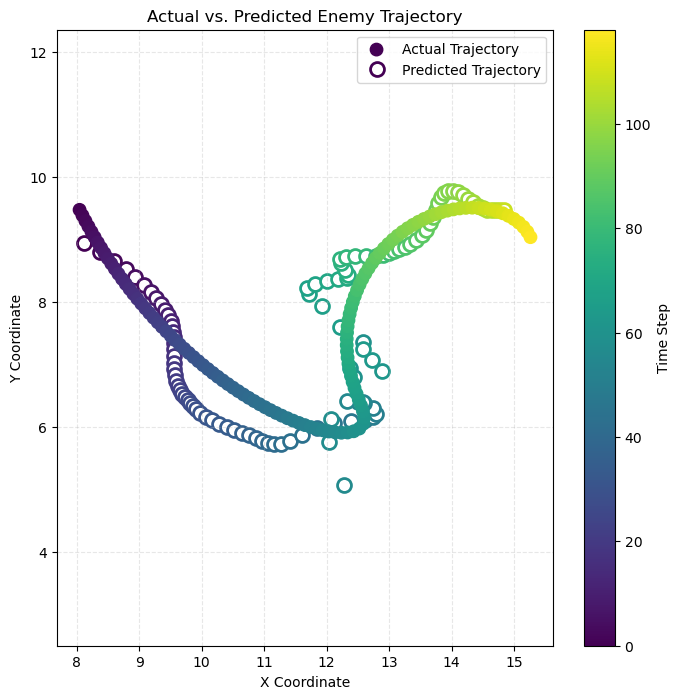

In [56]:
import matplotlib.pyplot as plt
import numpy as np

actual_trajectory = sample_enemy
predicted_trajectory = sample_predictions

plt.figure(figsize=(8, 8))

# Create color normalization
time_steps = np.arange(len(actual_trajectory))
norm = plt.Normalize(time_steps.min(), time_steps.max())

# Plot actual trajectory (solid points)
scatter_actual = plt.scatter(actual_trajectory[:, 0], 
                            actual_trajectory[:, 1], 
                            c=time_steps,
                            cmap='viridis',
                            norm=norm,
                            s=80,  # Slightly smaller size
                            marker='o',
                            label='Actual Trajectory',
                            zorder=2)  # Put actual points on top

# Plot predicted trajectory (hollow circles)
for i, (x, y) in enumerate(predicted_trajectory):
    color = plt.cm.viridis(norm(i))
    plt.plot(x, y, 'o', 
            markerfacecolor='white',  # White fill
            markeredgecolor=color,    # Colored edge matching the colormap
            markeredgewidth=2,        # Thick edge
            markersize=10,           # Size of markers
            label='Predicted Trajectory' if i == 0 else "",
            zorder=1)                # Put predicted points behind actual

# Add colorbar
plt.colorbar(scatter_actual, label='Time Step')

# Set axis limits and labels

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Actual vs. Predicted Enemy Trajectory')
plt.legend()

# Ensure equal aspect ratio
plt.axis('equal')

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()
